# 0.0. Data Imports

## 0.1. Load Libraries

In [2]:
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt

# statistics
from scipy import stats

# split data
from sklearn.model_selection import train_test_split
# Rescaling
from sklearn.preprocessing  import RobustScaler

# feature selection
from sklearn.feature_selection  import RFE
from boruta                 import BorutaPy

# machine learning model 
from xgboost              import XGBClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
from imblearn.ensemble    import BalancedRandomForestClassifier
from catboost             import CatBoostClassifier
from sklearn              import svm

# metrics
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score
from sklearn.metrics import recall_score, roc_curve, brier_score_loss, classification_report

# calibration
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

# cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# confusion matrix
from sklearn.metrics import confusion_matrix

# notebook settings
import warnings
import pickle
warnings.filterwarnings('ignore')
from IPython.core.display   import HTML
from IPython.display        import Image

# data analysis & data cleaning
import pandas as pd
import numpy as np
from random import choices as rchoice
from random import sample as rs

## 0.2. Functions

In [50]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option( 'display.expand_frame_repr', False ) 
    pd.options.display.float_format = '{:,.4f}'.format
    sns.set()

jupyter_settings()

def cramer_v(x, y):
    # Contingency Table (all combinations between categorical variables)
    cm = pd.crosstab(x, y)
    
    #chi2
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    phi = chi2/n
    phibiascorrect = max(0, phi - (k-1)*(r-1)/(n-1))
    k_denominator = k - (k-1)**2 / (n-1)
    r_denominator = r - (r-1)**2 / (n-1) 
    denominator = min(k_denominator-1, r_denominator-1)
    return np.sqrt(phibiascorrect / denominator)

def IQR(var):
    '''Calculate the lower and upper fence of a variable's boxplot. '''
    # IQR weight
    Q1 = np.quantile(df1[var], .25)
    Q3 = np.quantile(df1[var], .75)
    IQR = Q3 - Q1

    # calculate lower fence and using its value to eliminate outliers
    upper_fence = Q3 + (1.5 * IQR)
    lower_fence = Q1 - (1.5 * IQR)
    
    return print('For variable {}, upper fence is {} and lower fence is {}.'.format(var, upper_fence, lower_fence))

def get_descriptive_statistics(data):
    '''get descriptive statistics of a dataframe'''
    
    # 1st moment (mean)
    ct_mean = pd.DataFrame(data.apply( np.mean )).T
    # median
    ct_median = pd.DataFrame(data.apply( np.median )).T

    #### Dispersion
    # 2nd moment (variance)
    d_var = pd.DataFrame(data.apply( np.var)).T
    # Standard Deviation
    d_std = pd.DataFrame(data.apply( np.std)).T
    # min
    d_min = pd.DataFrame(data.apply(min)).T
    # max
    d_max = pd.DataFrame(data.apply(max)).T
    # range
    d_range = pd.DataFrame(data.apply(lambda x: x.max() - x.min())).T
    # 3rd moment (Skew)
    d_sk = pd.DataFrame(data.apply(lambda x: x.skew())).T
    # 4th moment (Kurtosis)
    d_kurt = pd.DataFrame(data.apply(lambda x: x.kurtosis())).T
    # Q1 quantile
    d_q1 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .25))).T
    # Q3 quantile
    d_q3 = pd.DataFrame(data.apply(lambda x: np.quantile(x, .75))).T

    # concatenate
    m = pd.concat([d_min, d_max, d_range, ct_mean, d_q1, ct_median, d_q3, d_std, d_sk, d_kurt]).T.reset_index()
    m.columns = ['attributes', 'min', 'max','range','mean','25%', '50%','75%','std', 'skew', 'kurtosis']
    
    return m


def ml_metrics(model_name, y_valid, y_hat, df_prob):
    '''Calculates the model performance and display metrics as a pandas dataframe.'''
    f1 = f1_score(y_valid, y_hat)
    accuracy = accuracy_score(y_valid, y_hat)
    kappa = cohen_kappa_score(y_valid, y_hat)
    roc_auc = roc_auc_score(y_valid, df_prob)
    precision = precision_score(y_valid, y_hat)
    recall = recall_score(y_valid, y_hat)
    brier = brier_score_loss(y_valid, df_prob, pos_label=1)

    return pd.DataFrame( {'Model Name': model_name,
                          'Recall': recall,
                          'Precision': precision,
                          'F1-Score': f1,
                          'ROC-AUC': roc_auc,
                          'Accuracy': accuracy,
                          'Kappa score': kappa,
                          'Brier score': brier}, index = [0])
        
def ml_performance(models, X_train, y_train, X_valid, y_valid, threshold, baseline):
    '''Calculate model performance according to a list of 
    provided classifiers, train, test dataset, and a probability threshold'''
    # create empty list to show results later on
    modeling_df = []
    for k, clf in enumerate(models):
        # print model to be trained
        print("Training " + type(clf).__name__ + "...")
        if str(clf) not in ["SVC(kernel='linear', random_state=42)","RidgeClassifier()"]:
            # fits the classifier to training data
            clf.fit(X_train, y_train)

            # predict the probabilities. This generates two-numpy arrays: 0 = prob of patient not having CVD, 1 = otherwise
            clf_prob = clf.predict_proba(X_valid)

            # data-framing the array 1 (only probabilities of having CVD), and naming the column as 'prob'
            df_prob = pd.DataFrame(clf_prob[:, 1], columns=['prob'])

            # apply threshold to dataframe 'probs'. If probabilities are higher than the threshold, we replace the probability value by 1 (has CVD) or 0 otherwise.
            y_hat = df_prob['prob'].apply(lambda x: 1 if x > threshold else 0)

            # calculate metrics and add to empty list
            modeling_result = ml_metrics(type(clf).__name__, y_valid, y_hat, df_prob)

            # add metrics in an empty list
            modeling_df.append(modeling_result)
            
        if str(clf) in ["SVC(kernel='linear', random_state=42)","RidgeClassifier()"]:
            # fits the classifier to training data
            clf.fit(X_train, y_train)

            # apply threshold to dataframe 'probs'. If probabilities are higher than the threshold, we replace the probability value by 1 (has CVD) or 0 otherwise.
            y_hat = clf.predict(X_valid)

            # calculate metrics and add to empty list
            modeling_result = ml_metrics(type(clf).__name__, y_valid, y_hat, df_prob)

            # add metrics in an empty list
            modeling_df.append(modeling_result)          
          
    if baseline == 'yes':
        ### add baseline model
        # Generating random probability numbers from 0 to 1
        baseline_yhat = rchoice(population = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], k = len(y_hat))

        # data-framing the array 1 (only probabilities of having CVD), and naming the column as 'prob'
        df_prob = pd.DataFrame(baseline_yhat, columns=['prob'])

        # apply threshold to dataframe 'probs'. 
        y_hat = df_prob['prob'].apply(lambda x: 1 if x > threshold else 0)
        baseline_model = ml_metrics('Baseline Model (Guess)', y_valid, y_hat, df_prob)

        # add metric in an empty list & concatenate dataframe
        modeling_df.append(baseline_model)
        final_df = pd.concat(modeling_df)
    else:
        # concatenate all classifier performances into a unique dataframe
        final_df = pd.concat(modeling_df)

    # return dataframe sorted by the f1-score
    return final_df.sort_values('F1-Score', ascending = False)

def feature_importance(n_rows, n_cols):
      
    # train classifiers 
    lr = LogisticRegression(max_iter=100, random_state=42)
    lr.fit(X_train, y_train)
    lr_prob = lr.predict_proba(X_valid)
    rfc = RandomForestClassifier(n_jobs=2, random_state=42)
    rfc.fit(X_train, y_train)
    rfc_prob = rfc.predict_proba(X_valid)
    brfc = BalancedRandomForestClassifier(random_state=42)
    brfc.fit(X_train, y_train)
    brfc_prob = brfc.predict_proba(X_valid)
    cb = CatBoostClassifier(random_state=42, verbose=False)
    cb.fit(X_train, y_train)
    cb_prob = cb.predict_proba(X_valid)
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train, y_train)
    xgb_prob = xgb.predict_proba(X_valid)
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
    lgbm.fit(X_train, y_train)
    lgbm_prob = lgbm.predict_proba(X_valid)
    
    feat_importance_list = [lr.coef_[0], rfc.feature_importances_, 
                        brfc.feature_importances_, cb.feature_importances_,
                       xgb.feature_importances_, lgbm.feature_importances_]
    model_name = ['Logistic Regression', 'Random Forest Classifier', 
                  'Balanced Random Forest Classifier','CatBoost Classifier',
                  'XGB Classifier','LGBM Classifier']
    
    # generate feature importance plots
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 20))
    sns.set(font_scale=1.5)
    for feature, name, n, ax in zip(feat_importance_list, model_name, list(range(n_rows*n_cols)), ax.flatten()):
        # get feature importance
        importance = feature
        
        # create dataframe
        df_imp = pd.DataFrame()
        
        # calculate importance of each variable
        df_imp['importance'] = pd.Series(importance, index=list(X_train.columns))
        
        # transform dataframe 
        long_df = pd.melt(df_imp.T)
        
        # plot barplot
        plt.subplot(n_rows, n_cols, n+1)
        sns.barplot(y = long_df.variable, x = long_df.value, order = long_df.sort_values('value',ascending = False)['variable'].to_list());
        plt.title(f'{name}');

    # adjusts subplot
    plt.tight_layout()

    # displays the plot
    plt.show()

def multiple_confusion_matrices(n_rows, n_cols, X_train, y_train, X_valid, y_valid, models, threshold = 0.50):
    # define subplots
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 16))
    
    for clf, ax, n in zip(models, ax.flatten(), list(range(n_rows*n_cols))):
        
        # fits the classifier to training data
        clf.fit(X_train, y_train)
        
        # predict the probabilities
        clf_probs = clf.predict_proba(X_valid)

        # keeps probabilities for the positive outcome only
        probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_default'])

        # applied the threshold
        y_pred = probs['prob_default'].apply(
            lambda x: 1 if x > threshold else 0)

        # plots confusion matrix as heatmap
        plt.subplot(n_rows, n_cols, n+1)
        single_confusion_matrix(y_valid, y_pred, model = clf)

    # adjusts subplot
    plt.tight_layout()

    # displays the plot
    plt.show()

def single_confusion_matrix(y_valid, y_pred, model, qualifier=""):
    # calculates confusion matrix
    cm = confusion_matrix(y_valid, y_pred)

    # plots confusion matrix as heatmap
    sns.set(font_scale=1)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                     square=True, annot_kws={"size": 16}, cbar_kws={"shrink": 0.4})

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    ax.title.set_text(type(model).__name__ + ' ' + str(qualifier))
    
def cross_validation(models, X, y, cv, qualifier=""):
    '''Calculate cross validation and display results in a dataframe'''
    # create empty list to show results later on
    cv_df = []
    for n in models:
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
                
        a1 = pd.DataFrame( {'Model Name': type(n).__name__ + ' ' + str(qualifier),
                      'Precision (Avg+Std) ': prec,
                      'Recall (Avg+Std) ': recall,
                      'F1-Score (Avg+Std)': f1_score,
                      'ROC-AUC (Avg+Std)': roc_auc,
                      'Accuracy (Avg+Std)': accuracy
                      }, index = [0])
    
        # add metrics in an empty list
        cv_df.append(a1)
    # concatenate all classifier performances into a unique dataframe
    final_df = pd.concat(cv_df)
        
    # return dataframe sorted by the f1-score
    return final_df

def random_search_lgbm(param, n_iterations, X, y):
    '''select the best parameters for the lgbm model'''
    # allocate all results in dataframe
    final_result = pd.DataFrame(columns=['mean f1-score', 'std', 'parameters'])
    for i in range( n_iterations ):
        # choose values for parameters randomly
        hp = { k: rs( v, 1 )[0] for k, v in param.items() }

        # model
        model_random_search = LGBMClassifier( objective='binary',
                                    num_leaves = hp['num_leaves'],
                                    min_data_in_leaf=hp['min_data_in_leaf'], 
                                    learning_rate=hp['learning_rate'], 
                                    n_estimators=hp['n_estimators'], 
                                    max_depth=hp['max_depth'], 
                                    colsample_bytree=hp['colsample_bytree'],
                                    min_child_weight=hp['min_child_weight'], random_state=42, n_jobs=-1).fit(X, y)

        # define CV strategy
        sk_fold = StratifiedKFold(n_splits=10, random_state=None)
        # calculate cross validation
        cv_scores = cross_val_score(model_random_search, X, y, cv = sk_fold, scoring='f1', n_jobs=-1)

        # append cv scores in dataframe
        result = pd.DataFrame([[mean(cv_scores), std(cv_scores), hp]], 
                            columns=['mean f1-score','std','parameters'])
        final_result = pd.concat( [final_result, result] )

    return final_result.sort_values('mean f1-score', ascending = False).head(10)

def plot_calibration_curve(model, name, fig_index, X_train, y_train, X_test, y_test):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(model, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(model, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1)


    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    df_scores = []
    for clf, name in [(lgbm, 'LGBM'),
                      (model, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = clf.predict_proba(X_test)[:, 1]
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)
    
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve) - with brier scores')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()   
    
def calibrated_scores(model, name, fig_index, X_train, y_train, X_test, y_test):
    """Plot calibration scores for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(model, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(model, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
    df_scores = []    
    for clf, name in [(lgbm, 'LGBM'),
                      (model, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        prob_pos = clf.predict_proba(X_test)[:, 1]
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
        a1 = pd.DataFrame( {'Model Name': name,
                          'Precision': precision_score(y_test, y_pred),
                          'Recall': recall_score(y_test, y_pred),
                          'F1-Score': f1_score(y_test, y_pred),
                          'ROC-AUC': roc_auc_score(y_test, y_pred),
                          'Accuracy': accuracy_score(y_test, y_pred),
                          'Kappa': cohen_kappa_score(y_test, y_pred),
                          'Brier Score': clf_score}, index = [0])
        df_scores.append(a1)
    # concatenate all classifier performances into a unique dataframe
    df_final = pd.concat(df_scores)
    return df_final


Populating the interactive namespace from numpy and matplotlib


# 1.0. STEP 01 - THE CHALLENGE

Cardio Catch Diseases is a healthcare business specialized in cardiovascular disease (CVD) diagnostic services. The firm's revenue streams come from only CVD diagnostics; therefore, the firm can increase its profit by:

1. Adding complementary services to the existing one;
2. Increasing the customer base size;
3. Increasing the frequency of diagnostics per patient;
4. Raising service price
5. Reducing fixed and variable costs;
6. Increasing the number of sponsors;
7. Improve service quality and use performance-based pricing strategy 

## 1.0. The Business Problem

Currently, the diagnosis of cardiovascular diseases is made manually by a team of specialists. **The current precision rate of the diagnosis varies between 55% and 65%**, due to the diagnosis' complexity and also the fatigue of the team who take turns to minimize the operation risks during the procedures. 

**The firm's price strategy is set as performance-based**: the better performance on diagnostics, the higher the price charged by the firm.

Details:
- **The cost of each diagnosis (including the devices and the payroll of the analysts) is around $1,000.00.** The price tag for the service varies according to the diagnosis precision achieved by the team of specialists. 

- **The client pays 500.00 for every 5% increase in diagnosis precision rate above 50%**. For example, for a precision rate of 55%, the diagnosis costs 500.00 for the client; while for a rate of 60%, the value is 1,000.00.

- **If the diagnostic accuracy is 50% or below, the customer does not pay for the service**.

**The firm's challenge is to stabilize the diagnostic's precision rate** in order to get more control over the future cash-flows of the firm. Since each diagnostic precision rate is unstable, the company wishes to use a more sophisticated tool than the existing one, which is a healthcare software solution that calculates precision according to some unknown thresholds on each of the following variables:

|Variable|Feature Type|Variable Name|Data Type|
|--|--|--|--|
|Age | Objective Feature | age | int (days)|
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code |
|Systolic blood pressure | Examination Feature | ap_hi | int |
|Diastolic blood pressure | Examination Feature | ap_lo | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Feature Type Description:
- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

Assumption: for binary variables, `1 = existence` and `0 = nonexistence`

## 1.2. Solution

Create a model that predicts the existence of cardiovascular diseases on patients by a precision rate **higher than 65%.**

## 1.3. Cardiovascular Diseases (CVD)

What is CVD? https://www.heart.org/en/health-topics/consumer-healthcare/what-is-cardiovascular-disease

What causes CVD? https://www.nhs.uk/conditions/cardiovascular-disease/
https://www.ecrjournal.com/articles/menopause-cholesterol-cardiovascular

Blood Pressure Readings: https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings
https://academic.oup.com/eurheartj/article/39/33/3021/5079119


Cholesterol vs Cardiovascular Diseases: https://www.healthline.com/health/high-cholesterol/levels-by-age

Cholesterol & High Blood Pressure: https://www.healthline.com/health/cholesterol-and-heart-disease#risk-factors

Glucose vs Cardiovascular Diseases: https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html
https://www.heartfoundation.org.au/heart-health-education/diabetes-and-heart-disease

Smoking vs cardiovascular diseases: https://www.hopkinsmedicine.org/health/conditions-and-diseases/smoking-and-cardiovascular-disease

Age vs CVD : Age above 65 more likely to have CVD https://www.nia.nih.gov/health/heart-health-and-aging
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3297980/

Obesity vs CVD: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6503652/

Alcohol vs CVD: https://alcoholthinkagain.com.au/alcohol-your-health/alcohol-and-your-long-term-health/alcohol-and-cardiovascular-disease/

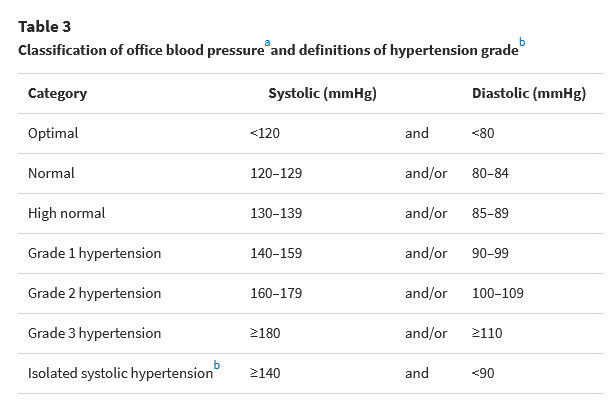

In [52]:
Image('img/classification.png')

# 2.0. STEP 02 - DATA PREPARATION

## 2.1. Load Dataset

In [3]:
# loading dataset
df1 = pd.read_csv('data/cardio_train.csv', low_memory = True, sep=';')
df1

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0000,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0000,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0000,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0000,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0000,135,80,1,2,0,0,0,1


At first look, seems like we will benefit from transforming the variable `age` from days to years right away:

In [4]:
df1['age'] = df1['age'].apply(lambda x: np.floor(x/360))

## 2.2. Data Dimensions

In [5]:
# printing data dimensions (columns vs rows)
print('Number of Columns: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Columns: 70000
Number of Columns: 13


## 2.4. Data Types & Null Values

We see here the data types present in the dataset. Some of them can be optimized to save memory space.

In [6]:
# general info of Counts and Data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  float64
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 6.9 MB


No missing values were detected

In [7]:
# Total number of null values
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 2.6. Change Data Types

In [8]:
# optimize memory
df1['age'] = df1['age'].astype(int16)
df1['height'] = df1['height'].astype(int16)
df1['ap_hi'] = df1['ap_hi'].astype(int16)
df1['ap_lo'] = df1['ap_lo'].astype(int16)
df1['cholesterol'] = df1['cholesterol'].astype(int8)
df1['gluc'] = df1['gluc'].astype(int8)
df1['smoke'] = df1['smoke'].astype(int8)
df1['alco'] = df1['alco'].astype(int8)
df1['active'] = df1['active'].astype(int8)
df1['cardio'] = df1['cardio'].astype(int8)

## 2.7. Descriptive Statistics

In [9]:
# getting statistics for all features
get_descriptive_statistics(df1)

,attributes,min,max,range,mean,25%,50%,75%,std,skew,kurtosis
0,id,0.0000,"99,999.0000","99,999.0000","49,972.4199","25,006.7500","50,001.5000","74,889.2500","28,851.0962",-0.0013,-1.1984
1,age,29.0000,65.0000,36.0000,53.5838,49.0000,54.0000,59.0000,6.8605,-0.3057,-0.8204
2,gender,1.0000,2.0000,1.0000,1.3496,1.0000,1.0000,2.0000,0.4768,0.6310,-1.6019
3,height,55.0000,250.0000,195.0000,164.3592,159.0000,165.0000,170.0000,8.2101,-0.6422,7.9437
4,weight,10.0000,200.0000,190.0000,74.2057,65.0000,72.0000,82.0000,14.3957,1.0121,2.5868
5,ap_hi,-150.0000,"16,020.0000","16,170.0000",128.8173,120.0000,120.0000,140.0000,154.0103,85.2962,"7,580.0747"
6,ap_lo,-70.0000,"11,000.0000","11,070.0000",96.6304,80.0000,80.0000,90.0000,188.4712,32.1141,"1,425.9146"
7,cholesterol,1.0000,3.0000,2.0000,1.3669,1.0000,1.0000,2.0000,0.6802,1.5871,0.9939
8,gluc,1.0000,3.0000,2.0000,1.2265,1.0000,1.0000,1.0000,0.5723,2.3975,4.2944
9,smoke,0.0000,1.0000,1.0000,0.0881,0.0000,0.0000,0.0000,0.2835,2.9059,6.4442


Some abnormal facts (outliers):
- **age & height**: minimum and maximum height values of 55cm and 250cm, being the youngest patient an adult (29yrs);
- **age & weight**: minimum value of 10kg, being the youngest patient an adult (29yrs)
- **ap_hi**: minimum and maximum systolic blood pressure of -150 and 16,020 mmHg;
- **ap_lo**: minimum and maximum diastolic blood pressure of -70 and 11,000 mmHg;

Some imbalanced features (high skew):
- **Negative, moderately skewed (between -1 and -0.5)**: height
- **Positive, moderately skewed (between 1 and 0.5)**: gender
- **Negative, highly skewed (lower than -1)**: active
- **Positive, moderately skewed (higher than 1)**: weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco

Features with significant presence of outliers (kurtosis > 3):
- height, ap_hi, ap_lo, gluc, smoke, alco

## 2.8. Outlier Analysis

In this section, we will explore and remove outliers for numerical variables height, ap_hi, ap_lo, and weight. For categorical variables, we will have the chance to explore them later on. 

In practice, one would consult the firm's business/medical team before removing outliers from the dataset. In this project, we will take assumptions according to online medical sources as we identify outliers.

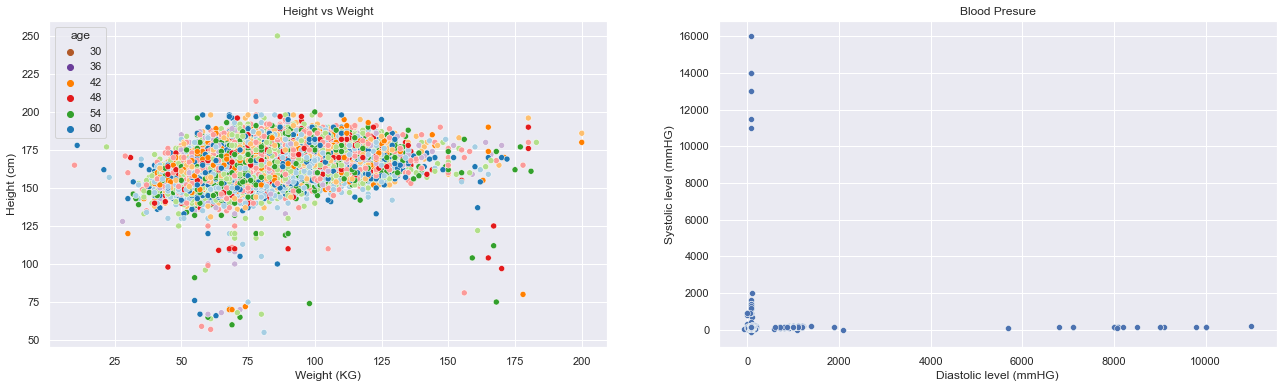

In [10]:
# setting plot size
plt.figure(figsize = (22,6))

# plotting scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x = 'weight', y = 'height', hue = 'age', data = df1, palette = 'Paired_r')
plt.ylabel('Height (cm)')
plt.xlabel('Weight (KG)')
plt.title('Height vs Weight');

# plotting scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x = 'ap_lo', y = 'ap_hi', data = df1)
plt.ylabel('Systolic level (mmHG)')
plt.xlabel('Diastolic level (mmHG)')
plt.title('Blood Presure');

Some things to note:
- There is one extremely tall patient with 250cm;
- Many patients with remarkably low weight (10~40kg)
- A few patients with extremely low height;
- A few patients with extremely high weight and low height;
- A few patients with extremely high height and low weight;
- Few negative/closer to zero systolic and diastolic levels;
- Few extreme systolic and diastolic levels;

Before we start removing outliers, let's check the boundary values for outliers by calculating the lower and upper fence of IQR boundaries for each

In [11]:
# calculating IQR boundaries for each variable
IQR('weight')
IQR('height')
IQR('ap_lo')
IQR('ap_hi')

For variable weight, upper fence is 107.5 and lower fence is 39.5.
For variable height, upper fence is 186.5 and lower fence is 142.5.
For variable ap_lo, upper fence is 105.0 and lower fence is 65.0.
For variable ap_hi, upper fence is 170.0 and lower fence is 90.0.


Given the values obtained above, we conclude that:
- **weight**: we won't use the boundaries as a threshold to eliminate outliers. Reason: patients weighting above 107kg and patients with dwarfism weighting below 39.5 is not uncommon. Further investigation is needed;
- **height**: we won't use the boundaries as a threshold to eliminate outliers. Reason: patients with height above 186.5cm and patients with height below 142.5 is not uncommon. Further investigation is needed;
- **ap_lo**: patients with diastolic level below 65 will be removed from the dataset. Further investigation is needed for diastolic levels above 105, since it is possible to have patients with such traits;
- **ap_hi**: patients with systolic level below 90 will be removed from the dataset. Further investigation is needed for systolic levels above 170, since it is possible to have patients with such traits;

### 2.8.1. Tall Patients (height > 200cm)

In [12]:
# filtering patients with height above 200cm
df1[df1['height'] > 200]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6486,9223,58,1,250,86.0000,140,100,3,1,0,0,1,1
21628,30894,52,2,207,78.0000,100,70,1,1,0,1,1,0


Seems like the patient with id 9223 is the current 2nd tallest person in the whole world with an impressive weight of 86kg. For a comparison, the tallest woman the world has even seen weighted was 254cm with 197 kg and the tallest men was 272cm with 199kg. We will remove this patient from the dataset

In [13]:
# removing patients with height = 250cm
df1 = df1[~(df1['height'] == 250)]

### 2.8.2. Short Patients (height < 100cm)

In [14]:
# filtering patients with height below 100cm
df1[df1['height'] < 100].sort_values('height', ascending = True)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,32456,64,1,55,81.0000,130,90,1,1,0,0,1,1
66643,95141,52,1,57,61.0000,130,90,1,1,0,0,1,1
64115,91523,51,1,59,57.6000,125,67,1,1,0,0,0,0
29157,41661,53,1,60,69.0000,110,70,1,1,0,0,0,0
27603,39462,58,1,64,61.0000,130,70,1,1,0,0,1,0
44490,63545,53,1,65,60.0000,120,80,1,1,0,0,1,0
33607,48009,54,2,65,72.0000,130,80,1,1,0,0,0,0
64454,92008,59,1,66,63.0000,12,80,1,1,0,0,0,1
50789,72476,40,2,67,60.0000,110,80,1,1,1,1,1,0
53344,76116,57,2,67,80.0000,120,80,1,1,0,0,0,1


In our dataset, we have many adult patients who have the height of babies, with the weight of adults. To design a height threshold to remove outliers, we will consider three measurements: the height averages for babies (as a baseline), the height average among people with dwarfism, and the height of the shortest person in the world.

- According to [Disabled Word](https://www.disabled-world.com/calculators-charts/height-weight-teens.php), babies with 0 to 23 months have an average height of 49.2 and 86.8cm respectively. Weight averages are 3.3kg and 11.9kg.

- The [average height among people with dwarfism](https://www.mayoclinic.org/diseases-conditions/dwarfism/symptoms-causes/syc-20371969) is 122cm.  

- The [smallest person in the world](https://www.guinnessworldrecords.com/news/2015/9/remembering-chandra-dangi-the-worlds-shortest-man-ever-396354) measures 76cm (height) and 28kg. 

Considering the fact that the youngest person in the dataset is 29 years old, it is unlikely that patients with height size below 86.8cm are adults. Even though the smallest person in the world is below that value, it is a very unlikely event to have patients with similar traits in our dataset. Therefore, **we will use 122cm as a threshold.**


In [15]:
# removing patients with height < 122cm
df1 = df1[~(df1['height'] < 122)]

### 2.8.3. Low weight

In [16]:
# printing dataset ordered from low to high weight
df1.sort_values('weight', ascending = True).head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
57858,82567,52,2,165,10.0000,180,1100,2,2,0,0,1,1
33817,48318,59,2,178,11.0000,130,90,1,1,0,0,1,1
60188,85931,60,1,162,21.0000,120,80,2,1,0,0,1,1
29488,42156,56,2,177,22.0000,120,80,1,1,1,1,1,0
26806,38312,64,1,157,23.0000,110,80,1,1,0,0,1,0
34276,48976,40,2,128,28.0000,120,80,1,1,0,0,1,0
60699,86650,52,1,171,29.0000,110,70,2,1,0,0,1,1
18559,26503,50,1,160,30.0000,120,80,1,1,0,0,1,1
41905,59853,59,1,143,30.0000,103,61,2,1,0,0,1,0
16906,24167,47,2,170,31.0000,150,90,2,2,0,0,1,1


We can observe patients with very unusual weight/height proportions. 
We will do the following:
- Remove patients with **very small height AND weight (48976, 59853)**;
- The average height of people with dwarfism is 122cm, and the average height and weight of male children aged 7 is 121.9cm and 22.9kg, respectively. (Source: [Disabled Word](https://www.disabled-world.com/calculators-charts/height-weight-teens.php)). **We will remove all patients with weight below 22.9kg**.
- Remove patients with **height-weight ratio equal or higher than 1:4.5**

A standard value for Height-weight ratio was not publicly available; therefore, we used a ratio value to detect very abnormal cases (patients with very low weight for the given height size).

In [17]:
# remove patients with very small height AND weight (48976, 5306, 59853)
df1 = df1.loc[~((df1['id'] == 48976) | (df1['id'] == 59853)), :]
# remove patients with weight below 22.9kg
df1 = df1[~(df1['weight'] < 22.9)]
# remove patients with height-weight ratio equal or higher than 1:4.5 
df1 = df1[~(df1['height'] / df1['weight'] >= 4.5)]

### 2.8.5. High weight

In [18]:
# printing dataset ordered from high to low weight
df1.sort_values('weight', ascending = False).head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
50413,71945,41,2,180,200.0000,150,90,1,1,0,0,1,1
435,618,46,1,186,200.0000,130,70,1,1,0,0,0,0
61285,87498,58,2,180,183.0000,110,80,3,3,0,1,1,1
36780,52564,54,1,161,181.0000,180,1100,2,1,0,0,1,1
61362,87612,46,2,196,180.0000,130,80,3,1,0,0,1,1
4743,6716,47,2,176,180.0000,140,90,1,1,0,0,1,1
45378,64829,48,2,190,180.0000,140,80,2,2,0,0,1,1
60592,86506,52,2,180,180.0000,140,100,3,1,0,0,1,1
20092,28683,57,2,165,178.0000,120,80,1,1,1,1,1,0
61788,88220,52,2,165,178.0000,120,80,1,1,0,0,1,0


In [19]:
df1[(df1['weight'] / df1['height'] > 1)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
389,552,46,2,165,169.0000,120,80,1,1,0,0,1,0
435,618,46,1,186,200.0000,130,70,1,1,0,0,0,0
2458,3470,65,2,159,165.0000,130,70,1,1,0,0,0,0
4743,6716,47,2,176,180.0000,140,90,1,1,0,0,1,1
6153,8757,58,1,122,161.0000,120,80,1,1,0,0,1,1
12435,17757,61,1,137,161.0000,150,100,2,1,0,0,0,1
15366,21958,48,1,125,167.0000,180,90,1,2,0,0,1,1
18952,27063,42,1,155,163.0000,180,100,1,1,0,0,1,1
20092,28683,57,2,165,178.0000,120,80,1,1,1,1,1,0
36780,52564,54,1,161,181.0000,180,1100,2,1,0,0,1,1


From the table above, we can observe very disproportional weight-height ratios. We will remove patients with weight-height ratio above 1:1.

**A standard value for weight-height ratio was not publicly available; therefore, we used a ratio value to detect very abnormal cases (patients with very high weight for the given height size).

In [20]:
df1 = df1[~(df1['weight'] / df1['height'] > 1)]

### 2.7.4. ap_hi (Systolic Blood Pressure)

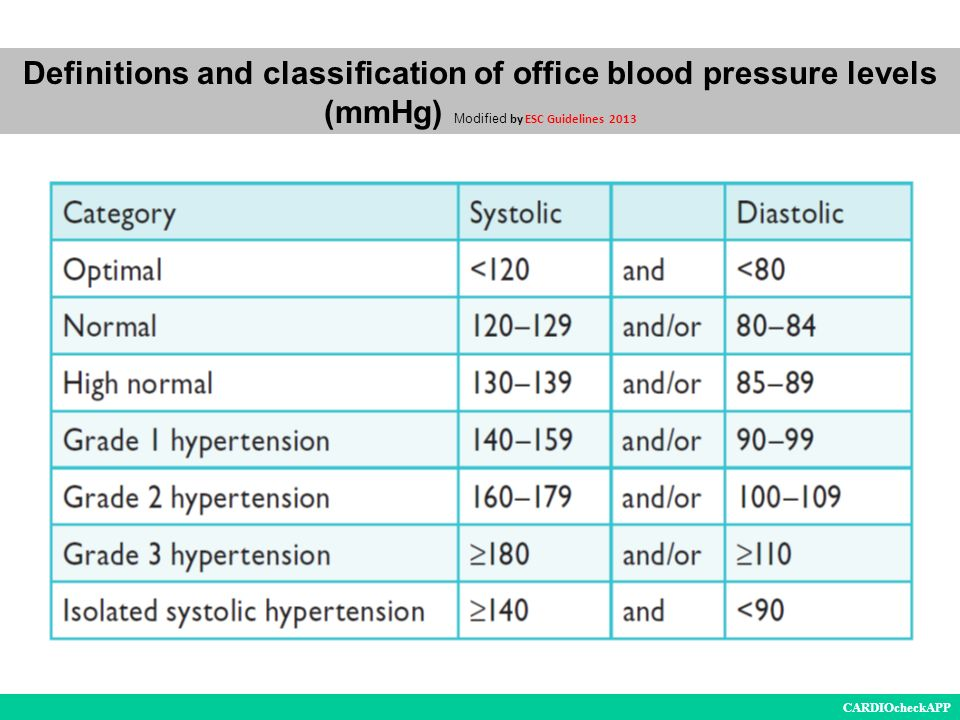

In [21]:
# remembering the blood pressure thresholds
Image('img/classification.png')

In [22]:
# filtering systolic values from descending order
df1.sort_values('ap_hi', ascending = False).head(100)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40852,58374,48,1,169,70.0000,16020,80,1,1,0,0,0,1
46912,66998,46,2,180,78.0000,14020,90,1,1,0,0,1,1
25464,36339,43,2,169,75.0000,14020,80,2,1,0,0,1,1
25519,36414,59,1,169,71.0000,14020,80,3,3,0,0,1,1
47253,67502,54,1,160,65.0000,14020,90,1,1,0,0,1,0
55847,79679,64,1,161,105.0000,13010,80,1,1,0,0,0,0
55459,79116,50,1,152,76.0000,13010,80,2,2,0,0,1,1
7763,11089,58,1,175,80.0000,11500,90,1,1,0,0,1,1
51438,73356,52,2,168,65.0000,11020,80,1,1,0,0,1,1
69370,99089,40,1,170,74.0000,2000,100,2,1,0,0,1,1


From the table, outliers are clear: systolic levels above 240 are just too extreme. We will remove them.

In [23]:
# removing outliers with high systolic levels
df1 = df1[~(df1['ap_hi'] > 240)]

Now let's check for outliers with negative or too low systolic values:

In [24]:
# filtering systolic values from ascending order
df1.sort_values('ap_hi', ascending = True).head(100)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35040,50055,64,2,168,59.0000,-150,80,1,1,0,0,1,1
23988,34295,50,1,162,74.0000,-140,90,1,1,0,0,1,1
46627,66571,65,2,160,59.0000,-120,80,1,1,0,0,0,0
25240,36025,40,2,168,50.0000,-120,80,2,1,0,0,0,1
16021,22881,61,2,161,90.0000,-115,70,1,1,0,0,1,0
20536,29313,43,1,153,54.0000,-100,70,1,1,0,0,1,0
4607,6525,42,1,165,78.0000,-100,80,2,1,0,0,1,0
8757,12494,46,2,163,63.0000,1,2088,1,1,1,0,1,0
42334,60477,51,1,171,80.0000,1,1088,1,1,0,0,1,1
5382,7657,59,1,162,69.0000,7,80,1,1,0,0,1,0


Three things worth noting from the table above:
1. We will remove **negative entries** from the dataset.
2. **There are many systolic values from 10 to 19** which could indicate data entry error. Since we don't know what happened, we will discard these entries.
3. We will remove all patients with systolic level **below the lower fence (90)**

In [25]:
df1 = df1[df1['ap_hi'] > 90]

### 2.7.5. ap_lo (Diastolic Blood Pressure)

In [26]:
# filtering diastolic values from descending order
df1.sort_values('ap_lo', ascending = False).head(100)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
43326,61901,64,1,160,105.0000,200,11000,1,1,0,0,1,1
68538,97907,52,1,166,70.0000,160,10000,2,1,0,0,1,1
23849,34098,50,2,169,86.0000,150,10000,2,2,0,1,1,1
2381,3352,58,2,186,105.0000,140,10000,1,1,0,0,1,1
43434,62058,60,2,179,62.0000,130,9800,1,1,0,0,1,0
6653,9482,54,1,162,69.0000,130,9100,1,1,0,0,1,1
32920,47030,50,1,156,65.0000,150,9011,2,2,0,0,1,1
12086,17260,59,2,169,78.0000,130,9011,1,1,1,1,1,1
15990,22832,40,2,179,70.0000,120,8500,1,1,0,0,1,0
44042,62921,58,1,165,74.0000,120,8200,2,3,0,0,1,0


In [27]:
# filtering diastolic values above 180
df1[df1['ap_lo'] > 170].sort_values('ap_lo').head(100)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
37144,53070,52,2,175,75.0000,150,180,1,1,0,0,0,1
48191,68825,53,1,164,98.0000,95,180,3,3,0,1,1,1
43998,62861,62,2,163,70.0000,200,180,1,1,0,0,0,1
19925,28449,63,1,160,88.0000,150,180,1,1,0,0,0,1
38022,54282,60,1,161,84.0000,196,182,2,2,0,0,1,1
63924,91264,44,1,164,69.0000,130,190,1,1,0,0,1,0
49303,70400,61,1,157,86.0000,170,190,2,2,0,1,1,1
69320,99006,58,2,168,63.0000,120,602,1,1,0,0,0,0
56549,80714,65,2,168,74.0000,130,700,1,1,1,1,1,0
15565,22240,40,2,176,67.0000,130,708,1,2,1,1,1,0


In [28]:
# filtering diastolic values from ascending order
df1.sort_values('ap_lo', ascending = True).head(100)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
63787,91073,40,2,161,61.0000,117,0,1,1,0,0,1,0
48049,68612,52,1,160,84.0000,121,0,1,1,0,0,0,1
38370,54780,64,2,170,81.0000,148,0,1,1,0,0,1,0
27686,39577,64,2,180,73.0000,140,0,1,1,1,1,1,1
13489,19258,41,2,150,60.0000,130,0,1,1,0,0,0,0
17381,24837,50,1,164,78.0000,138,0,1,1,0,0,1,0
16459,23512,56,1,156,50.0000,138,0,3,1,0,0,1,1
56950,81298,42,1,164,70.0000,120,0,1,1,0,0,1,0
22923,32749,58,2,166,68.0000,149,0,1,1,0,0,1,1
65303,93224,65,2,176,99.0000,120,0,1,3,0,0,1,1


Three things worth noting from the table above:
1. Many inconsistent data that could be caused by data entry error or some miscalculation (wrong measurement)
2. After diastolic values surpasses the 190 mark, numbers began to assume unrealistic values. **We will remove all diastolic values above 190.**
3. For the lower end of the data, we will calculate the IQR and use the lower fence to remove the remnant outliers. 

**Patients with diastolic values higher than systolic values** will also be removed.

In [29]:
# remove diastolic values above 190
df1 = df1[df1['ap_lo'] <= 190]
# remove diastolic values below the lower fence 65
df1 = df1[(df1['ap_lo'] > 65)]

In [30]:
# how many outliers were removed from the dataset?
print('{:.2f}% of the data was removed'.format((100 - (df1.shape[0]/70000)*100)))

6.45% of the data was removed


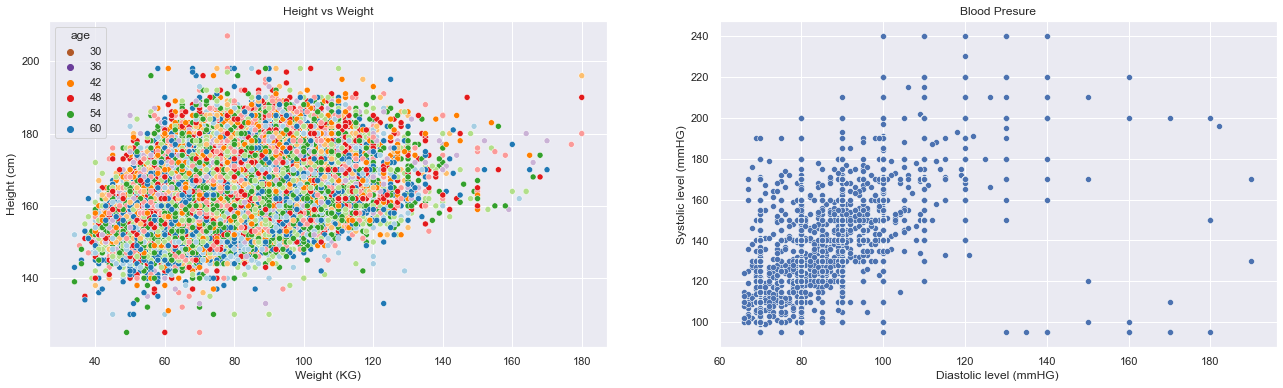

In [31]:
# setting plot size
plt.figure(figsize = (22,6))

# plotting scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x = 'weight', y = 'height', hue = 'age', data = df1, palette = 'Paired_r')
plt.ylabel('Height (cm)')
plt.xlabel('Weight (KG)')
plt.title('Height vs Weight');

# plotting scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x = 'ap_lo', y = 'ap_hi', data = df1)
plt.ylabel('Systolic level (mmHG)')
plt.xlabel('Diastolic level (mmHG)')
plt.title('Blood Presure');

In [32]:
get_descriptive_statistics(df1)

,attributes,min,max,range,mean,25%,50%,75%,std,skew,kurtosis
0,id,0.0000,"99,999.0000","99,999.0000","49,964.3978","24,971.5000","50,000.0000","74,857.5000","28,845.1812",-0.0016,-1.1977
1,age,30.0000,65.0000,35.0000,53.6945,49.0000,54.0000,59.0000,6.8246,-0.3208,-0.7990
2,gender,1.0000,2.0000,1.0000,1.3539,1.0000,1.0000,2.0000,0.4782,0.6110,-1.6268
3,height,125.0000,207.0000,82.0000,164.5382,159.0000,165.0000,170.0000,7.8450,0.1021,0.2116
4,weight,34.0000,180.0000,146.0000,74.4607,65.0000,72.0000,82.0000,14.1784,0.9545,1.9758
5,ap_hi,95.0000,240.0000,145.0000,127.7412,120.0000,120.0000,140.0000,15.9783,1.1750,2.0572
6,ap_lo,66.0000,190.0000,124.0000,82.3196,80.0000,80.0000,90.0000,8.5513,1.1713,5.1394
7,cholesterol,1.0000,3.0000,2.0000,1.3709,1.0000,1.0000,2.0000,0.6848,1.5721,0.9336
8,gluc,1.0000,3.0000,2.0000,1.2288,1.0000,1.0000,1.0000,0.5756,2.3806,4.2020
9,smoke,0.0000,1.0000,1.0000,0.0884,0.0000,0.0000,0.0000,0.2839,2.8992,6.4053


As a result of removing outliers, **6.48% of the data was removed.**

# 3.0. STEP 03 - FEATURE ENGINEERING

In [33]:
# Save Step 02 data
# pickle.dump( df1, open( 'data\df1.pkl', 'wb' ) )

# Load Step 02 data
df3 = pickle.load(open ('data\df1.pkl', 'rb'))


## 3.1. Hypothesis Mindmap

To guide the feature engineering process, we mapped the main factors that influence the incidence of CVD on patients below:

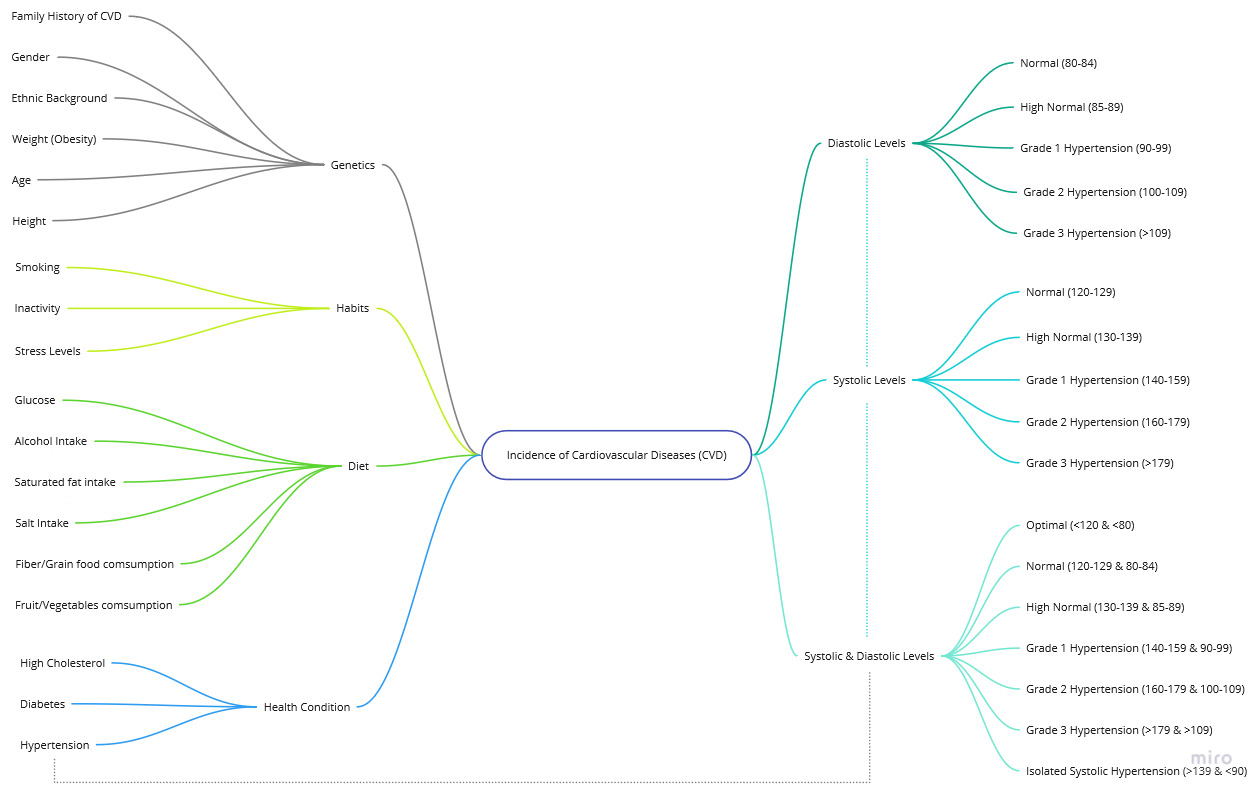

In [34]:
Image('img/hypothesis.jpg')

## 3.2. Hypothesis Creation

Ideally, we would draw a hypothesis list for each factor drawn in the mindmap. Due to the lack of data, the following hypotheses can be tested in this project: 

#### H1. More than 50% of patients with CVD are of gender 1.

#### H2. The proportion of CVD cases surpass of non-CVD cases in patients weighting above 90kg.


#### H3. The proportion of CVD cases surpass of non-CVD cases in patients aged 50 or above.


#### H4. The average height among patients with CVD and without CVD is different with a confidence interval of 95%


#### H5. More than 70% of patients with CVD are patients who smoke.

#### H6. More than 70% of patients with CVD are physically inactive.


#### H7. More than 70% of patients with CVD are under the "well above" glucose level category.


#### H8. At least 30% of patients with CVD are patients who drink alcohol.


#### H9. At least 30% of patients with CVD are under the "well above" cholesterol level category.


#### H10. The average BMI among patients with CVD and without CVD is different with a confidence interval of 95%


#### H11. More than 50% of patients have hypertension (Grade 1 Hypertension or above)


#### H12. More than 70% of patients with CVD have a CVD Risk Scale of "high" or above.

## 3.3. Guided Feature Engineering

### 3.3.1. Blood Pressure

We will classify our patients into hypertension grades as the table below shows:

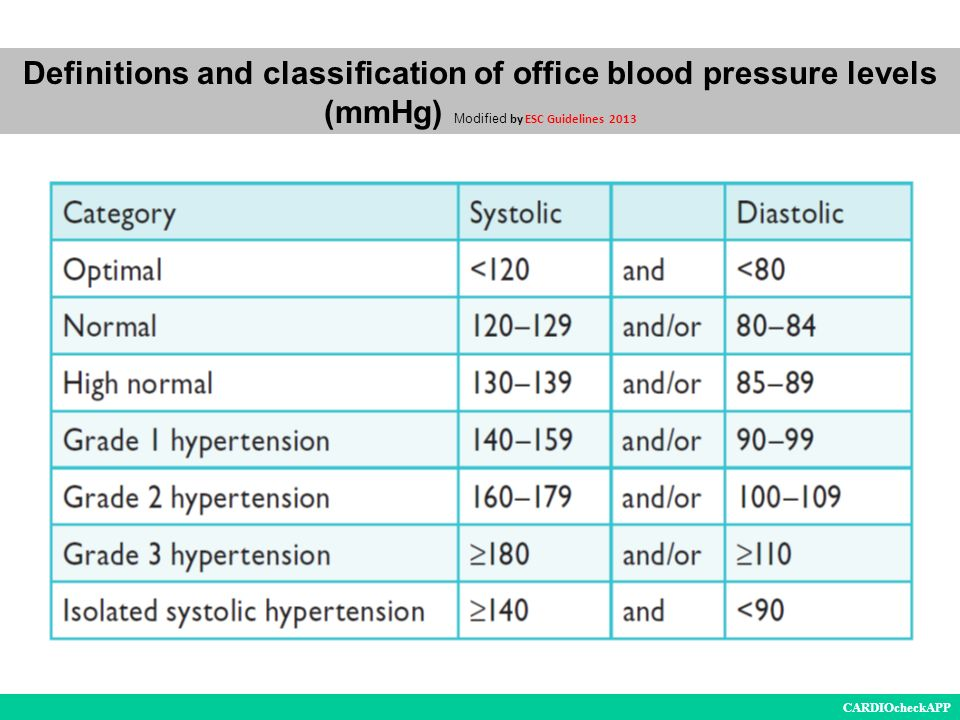

In [35]:
Image('img/classification.png')

In [36]:
# Create support variable 'systolic' 
df3['systolic'] = df3['ap_hi'].apply(lambda x: 'normal' if x <= 129 
                                     else 'high_normal' if 130 <= x <= 139 
                                     else 'grade_1' if 140 <= x <= 159
                                     else 'grade_2' if 160 <= x <= 179 
                                     else 'grade_3')

# Create support variable 'diastolic' 
df3['diastolic'] = df3['ap_lo'].apply(lambda x: 'normal' if x <= 84 
                                     else 'high_normal' if 85 <= x <= 89 
                                     else 'grade_1' if 90 <= x <= 99
                                     else 'grade_2' if 100 <= x <= 109 
                                     else 'grade_3')

# Create variable 'sys_diast'. This variable classifies each patient according to both systolic and diastolic levels:
df3['sys_diast'] = df3.apply(lambda x: 'normal' if (x['systolic'] == 'normal') & (x['diastolic'] == 'normal')
                             else 'high_normal' if (x['systolic'] == 'high_normal') & (x['diastolic'] == 'high_normal')
                             else 'high_normal' if (x['systolic'] == 'normal') & (x['diastolic'] == 'high_normal')
                             else 'high_normal' if (x['systolic'] == 'high_normal') & (x['diastolic'] == 'normal')
                             else 'grade_1' if (x['systolic'] == 'grade_1') & (x['diastolic'] == 'grade_1')
                             else 'grade_1' if (x['systolic'] == 'grade_1') & (x['diastolic'] == 'high_normal')
                             else 'grade_1' if (x['systolic'] == 'high_normal') & (x['diastolic'] == 'grade_1')
                             else 'grade_1' if (x['systolic'] == 'grade_1') & (x['diastolic'] == 'normal')
                             else 'grade_1' if (x['systolic'] == 'normal') & (x['diastolic'] == 'grade_1')
                             else 'grade_2' if (x['systolic'] == 'grade_2') & (x['diastolic'] == 'grade_2')
                             else 'grade_2' if (x['systolic'] == 'grade_2') & (x['diastolic'] == 'grade_1')
                             else 'grade_2' if (x['systolic'] == 'grade_1') & (x['diastolic'] == 'grade_2')
                             else 'grade_2' if (x['systolic'] == 'grade_2') & (x['diastolic'] == 'normal')
                             else 'grade_2' if (x['systolic'] == 'normal') & (x['diastolic'] == 'grade_2')
                             else 'grade_2' if (x['systolic'] == 'grade_2') & (x['diastolic'] == 'high_normal')
                             else 'grade_2' if (x['systolic'] == 'high_normal') & (x['diastolic'] == 'grade_2')
                             else 'grade_3' if (x['systolic'] == 'grade_3') & (x['diastolic'] == 'grade_3')
                             else 'grade_3' if (x['systolic'] == 'grade_3') & (x['diastolic'] == 'grade_2')
                             else 'grade_3' if (x['systolic'] == 'grade_2') & (x['diastolic'] == 'grade_3')
                             else 'grade_3' if (x['systolic'] == 'grade_3') & (x['diastolic'] == 'grade_1')
                             else 'grade_3' if (x['systolic'] == 'grade_1') & (x['diastolic'] == 'grade_3')
                             else 'grade_3' if (x['systolic'] == 'grade_3') & (x['diastolic'] == 'high_normal')
                             else 'grade_3' if (x['systolic'] == 'high_normal') & (x['diastolic'] == 'grade_3')
                             else 'grade_3' if (x['systolic'] == 'grade_3') & (x['diastolic'] == 'normal')
                             else 'grade_3' if (x['systolic'] == 'normal') & (x['diastolic'] == 'grade_3')
                             else 'unknown', axis = 1)

# include optimal and isolated cases in variable 'sys_diast'
df3.loc[(df3['ap_hi'] < 120) & (df3['ap_lo'] < 80), 'sys_diast'] = 'optimal'
df3.loc[(df3['ap_hi'] >= 140) & (df3['ap_lo'] < 90), 'sys_diast'] = 'isolated'

# create dummy variable hyper to indicate 1 = patient has hypertension; 0 = otherwise.
df3['hyper'] = df3['sys_diast'].apply(lambda x: 0 if (x == 'normal') | (x == 'optimal') | (x == 'high_normal')
                                      else 1)

### 3.3.2. BMI

For this project, the Body Mass Index (BMI) will be included as a new variable. The following tables will help us calculating the BMI:

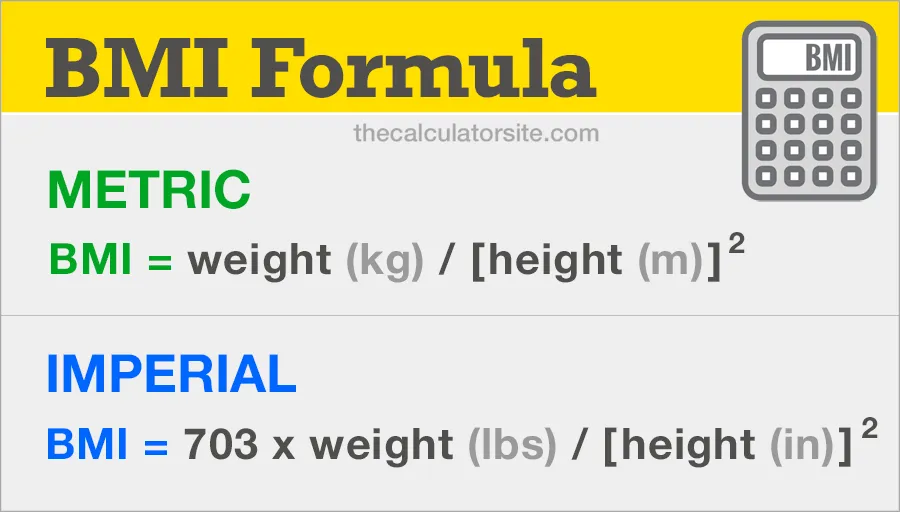

In [37]:
# BMI Formula retrieved from [thecalculatorsite.com](https://www.thecalculatorsite.com/articles/health/bmi-formula-for-bmi-calculations.php)
Image('img/bmi-formula.PNG')

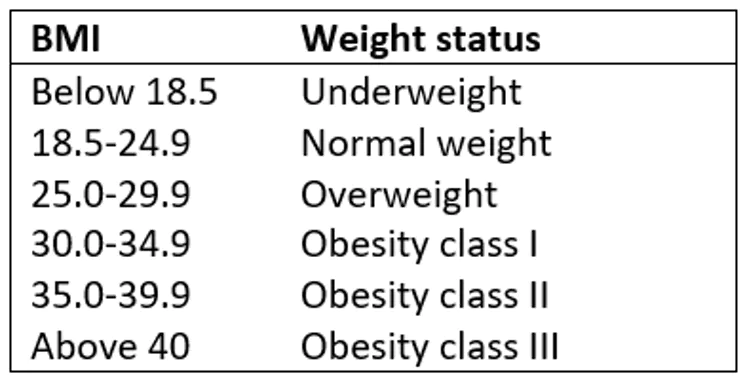

In [38]:
# BMI Table (obtained from [The Conversation](https://theconversation.com/body-mass-index-may-not-be-the-best-indicator-of-our-health-how-can-we-improve-it-143155))
Image('img/bmi.PNG')


In [39]:
# create bmi variable
df3['bmi'] = (df3['weight']) / (df3['height'] / 100)**2
# create bmi_class variable with classification
df3['bmi_class'] = df3['bmi'].apply(lambda x: 'underweight' if x < 18.5
                                    else 'normal' if (x >= 18.5) & (x < 25)
                                    else 'overweight' if (x >= 25) & (x < 30)
                                    else 'obesity_1' if (x >= 30) & (x < 35)
                                    else 'obesity_2' if (x >= 35) & (x < 40)
                                    else 'obesity_3'
                                   )
# encoding bmi_class to support the new variable cvd_risk (to be created next)

df3['bmi_class_enc'] = df3['bmi_class'].apply(lambda x: 0 if x == 'underweight' 
                                    else 0 if x == 'normal'
                                    else 1 if x == 'overweight'
                                    else 2 if x == 'obesity_1'
                                    else 3 if x == 'obesity_2' 
                                    else 4)

### 3.3.3. CVD Risk Scale

To summarize all health conditions that influence the incidence of CVDs, we will create a CVD Risk Scale variable `cvd_risk` that sums the integer variables `gluc`, `cholesterol`, `smoke`, `alco`, `active`, `hyper`, and `bmi_class_enc`.
- `gluc`: variable goes from 1 to 3, being the highest value the riskiest for the patient. Variable will be rescaled from 0 to 2 before creating `cvd_risk`;
- `cholesterol`: variable goes from 1 to 3, being the highest value the riskiest for the patient. Variable will be rescaled from 0 to 2 before creating `cvd_risk`;
- `bmi_class_enc`: variable goes from 0 to 4, being the highest value ther riskiest for the patient.
- `smoke`, `alco`: dummy variable where 1 represents a risk for the patient to develop CVD
- `active`: dummy variable where 1 represents less CVD risk (patient is physically active). We will create a new variable that inverts the dummy order and drop it afterwards.

The only way to tell that patients doesn't have CVD risk is by earning a zero CVD risk value.

In [40]:
# rescaling gluc
df3['gluc'] = df3['gluc'].apply(lambda x: 0 if x == 1
                                    else 1 if x == 2
                                    else 2)
# rescaling cholesterol
df3['cholesterol'] = df3['cholesterol'].apply(lambda x: 0 if x == 1
                                    else 1 if x == 2
                                    else 2)

# creating new variable 'active_scale'
df3['active_scale'] = df3['active'].apply(lambda x: 0 if x == 1
                                    else 1) 

# creating CVD Risk scale variable cvd_risk
df3['cvd_risk'] = df3['gluc'] + df3['cholesterol'] + df3['bmi_class_enc'] + df3['smoke'] + df3['alco'] + df3['active_scale']

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

## 4.1. Univariate Analysis

In [41]:
# # Save Step 03 data
# pickle.dump( df3, open( 'data\df3.pkl', 'wb' ) )

# Load Step 02 data
df5 = pickle.load(open ('data\df3.pkl', 'rb'))

### 5.1.1. Target Variable

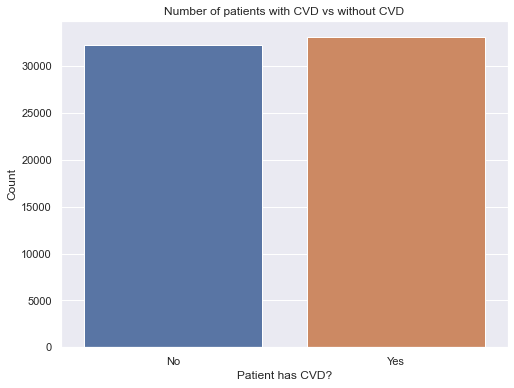

In [42]:
# set plot size
plt.figure(figsize = (8,6))
sns.countplot(df5['cardio']);
plt.title('Number of patients with CVD vs without CVD');
plt.xlabel('Patient has CVD?');
plt.ylabel('Count');
plt.xticks(ticks=[0,1], labels=['No','Yes']);

In [43]:
print('Number of patients with CVD: {}'.format(df5[df5['cardio'] == 1].shape[0]))
print('Number of patients without CVD: {}'.format(df5[df5['cardio'] == 0].shape[0]))

Number of patients with CVD: 33171
Number of patients without CVD: 32292


Number of patients are balanced for the target variable.

### 5.1.2. Numerical Variables

In this dataset, the variables considered "numerical" are: `age`, `height`, `weight`, `ap_hi`, `ap_lo`, `bmi`

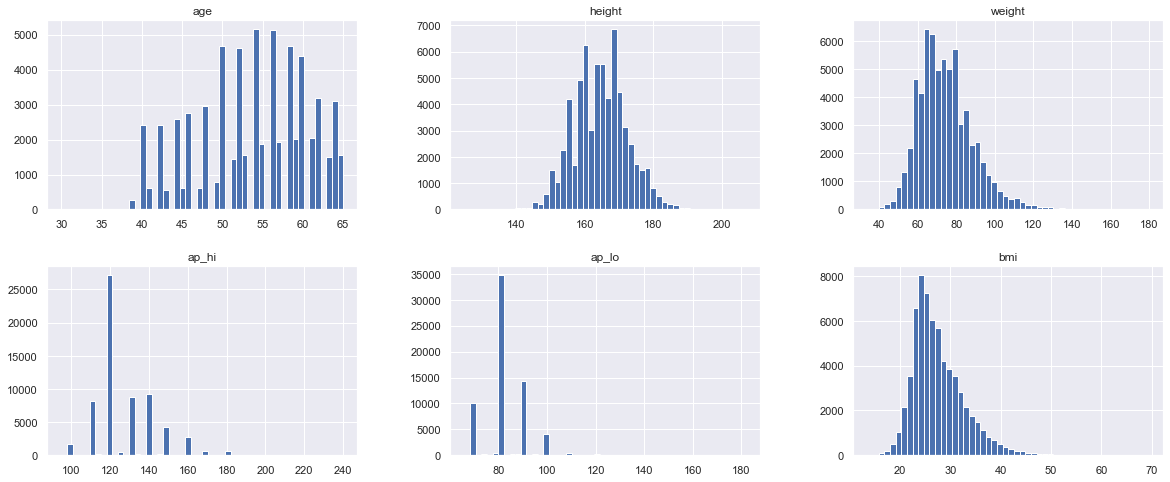

In [44]:
num_var = df5[['age','height','weight','ap_hi','ap_lo','bmi']]
num_var.hist(bins = 50, figsize = (20,8), layout = (2,3));

Highlights:
- **Age**: there is a concentration of patients aged 50 to 60;
- **Height**: distribution concentrates around height of 160cm in a normal shape;
- **Weight**: distribution is slightly shifted to the left. Data concentrated around 70kg;
- **Systolic Pressure (ap_hi)& Diastolic Pressure (ap_lo)**: Systolic and Diastolic measurements concentrated around 120/80mmHg - normal blood pressure;
- **BMI**: distribution is slighly shifted to the left, concentrated around 25mmHg;

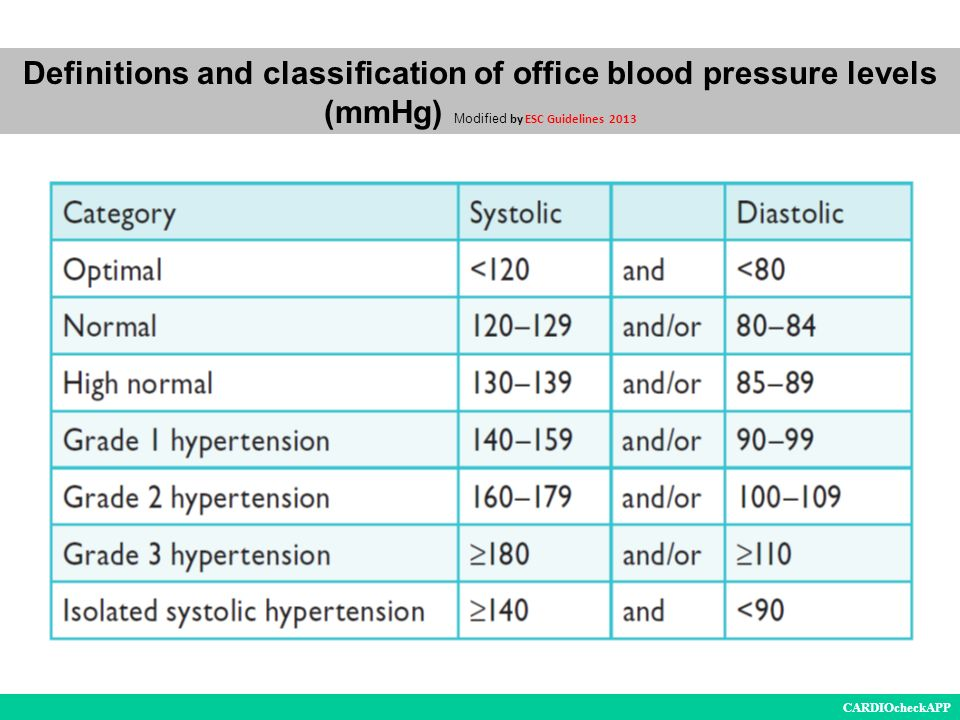

In [45]:
Image('img/classification.png')

### 5.1.2. Categorical Variables

In [46]:
cat_feat = df5[['gender','cholesterol','gluc','smoke','alco','active','systolic','diastolic',
               'sys_diast','hyper','bmi_class','cvd_risk','cardio']]
cat_feat

,gender,cholesterol,gluc,smoke,alco,active,systolic,diastolic,sys_diast,hyper,bmi_class,cvd_risk,cardio
0,2,0,0,0,0,1,normal,normal,normal,0,normal,0,0
1,1,2,0,0,0,1,grade_1,grade_1,grade_1,1,obesity_1,4,1
2,1,2,0,0,0,0,high_normal,normal,high_normal,0,normal,3,1
3,2,0,0,0,0,1,grade_1,grade_2,grade_2,1,overweight,1,1
5,1,1,1,0,0,0,normal,normal,normal,0,overweight,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,2,0,0,1,0,1,normal,normal,normal,0,overweight,2,0
69996,1,1,1,0,0,1,grade_1,grade_1,grade_1,1,obesity_3,6,1
69997,2,2,0,0,1,0,grade_3,grade_1,grade_3,1,obesity_1,6,1
69998,1,0,1,0,0,0,high_normal,normal,high_normal,0,overweight,3,1


In [47]:
# Encoding numbered categorical variables with text for univariate analysis

cat_feat['cholesterol'] = cat_feat['cholesterol'].apply(lambda x: 'normal' if x == 1
                                             else 'above_normal' if x == 2
                                             else 'well_above')
cat_feat['gluc'] = cat_feat['gluc'].apply(lambda x: 'normal' if x == 1
                                             else 'above_normal' if x == 2
                                             else 'well_above')
cat_feat['smoke'] = cat_feat['smoke'].apply(lambda x: 'yes' if x == 1
                                             else 'no')
cat_feat['alco'] = cat_feat['alco'].apply(lambda x: 'yes' if x == 1
                                             else 'no')
cat_feat['active'] = cat_feat['active'].apply(lambda x: 'yes' if x == 1
                                             else 'no')
cat_feat['hyper'] = cat_feat['hyper'].apply(lambda x: 'yes' if x == 1
                                             else 'no')

# for cvd_risk, we will assume the following thresholds: 
# [0 to 1] - very low risk
# [2 to 4] - low risk
# [4 to 6] - medium risk
# [6 to 8] - high risk
# [8 to 10] - very high risk

cat_feat['cvd_risk'] = cat_feat['cvd_risk'].apply(lambda x: 'very_low' if x < 2
                                             else 'low' if 1 < x < 4
                                             else 'medium' if 3 < x < 6
                                             else 'high' if 6 < x < 9
                                             else 'very_high')


ValueError: num must be 1 <= num <= 12, not 13

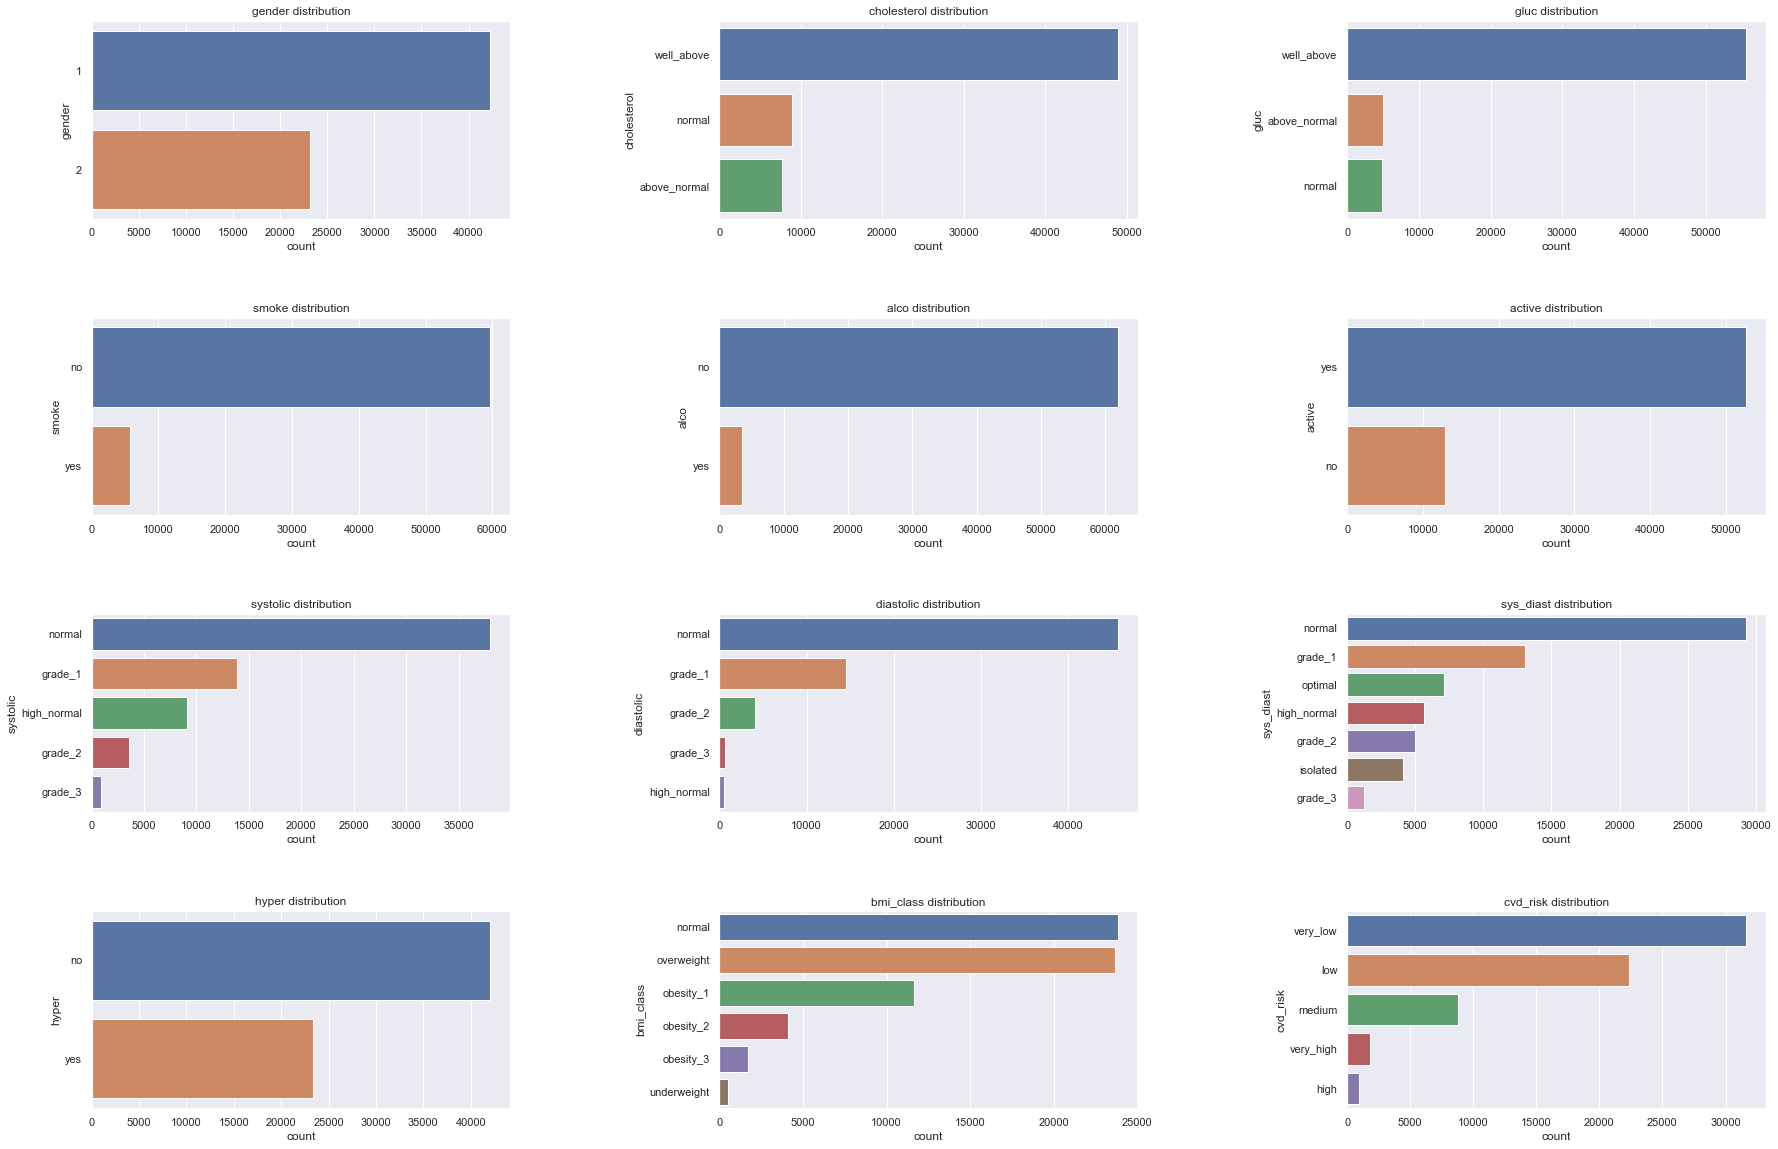

In [48]:
# set plot size
plt.figure(figsize = (30,20))
#     sns.countplot(y = cat_feat['{}'.format(n)], order = cat_feat['{}'.format(n)].value_counts().index);

for k, n in enumerate(cat_feat.columns):
    plt.subplot(4,3,k+1)
    sns.countplot(y = cat_feat['{}'.format(n)], order = cat_feat['{}'.format(n)].value_counts().index);
    plt.title('{} distribution'.format(n))
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)

Highlights:
- **Gender**: There are almost twice patients of gender 1 than 2;
- **Cholesterol**: Number of patients with "well-above" cholesterol levels are 5x bigger than others;
- **Glucose**: Number of patients with "well-above" glucose levels are 5x bigger than others;
- **Smoke**: Number of non-smoker patients are 6x bigger than smokers;
- **Alcohol**: Number of patients who aren't alcohol consumers are 5x bigger than patients who are alcohol consumers;
- **Active**: Number of physically active patients are almost 5x bigger than sedentary patients;
- **Systolic**: Around 60% of patients have normal systolic levels. Grade 1 Hypertension patients make up for around 20% of patients, followed by "High Normal" (15%), Grade 2 Hypertension, and Grade 3 Hypertension patients;
- **Diastolic**: Around 70% of patients have normal systolic levels. Grade 1 Hypertension patients make up for around 20% of patients, followed by Grade 2 Hypertension, "High Normal", and Grade 3 Hypertension patients;
- **Systolic + Diastolic**: Around 50% of patients have normal blood pressure levels. Grade 1 Hypertension patients make up for around 20% of patients, followed by "Optimal", "High-Normal", Grade 2 Hypertension, "Isolated", and Grade 3 Hypertension patients;
- **Hypertension**: Around 60% of patients doesn't have hypertension;
- **BMI**: Around 70% of patients have normal or overweight BMI levels. Obesity Class 1 patients make up for around 20%, followed by Obesity class 2, class 3, and underweight.
- **CVD Risk Scale**: The scale suggests that around 90% of patients have very low or low risk of having CVD. Further investigation will be needed.

## 4.2. Bivariate Analysis

In this analysis, hypothesis derived in the feature engineering section will be tested against the target variable.

### H1. More than 50% of patients with CVD are of gender 1.
**TRUE**: More than 60% of patients with CVD are of gender 1. In addition, we see that the number of patients without and with CVD is balanced across genders.

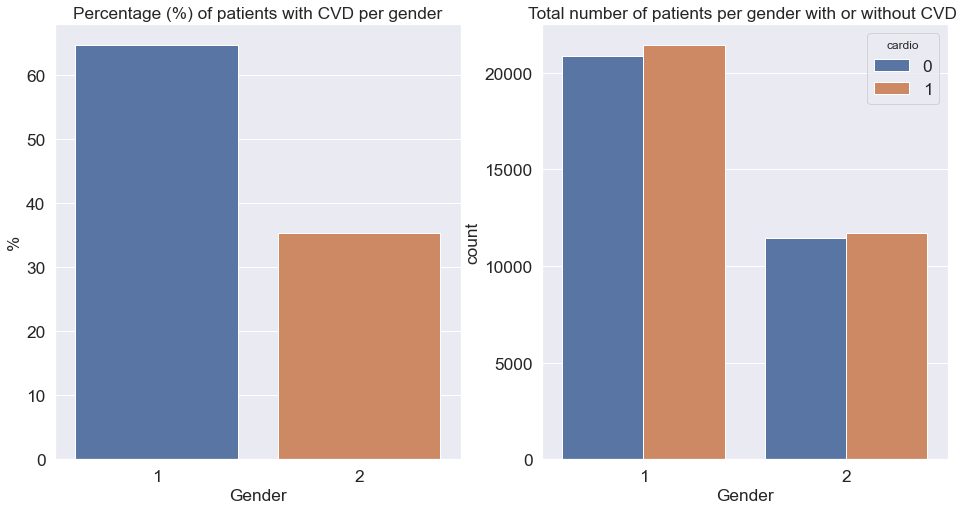

In [90]:
# set plot size
plt.figure(figsize = (16,8))

#set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = df5[df5['cardio'] == 1]
# aggregate data for gender
aux2 = (aux1[['gender','cardio']].groupby('gender').count()/len(aux1)*100).reset_index()
sns.barplot(x = 'gender', y = 'cardio', data = aux2)
plt.xlabel("Gender")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD per gender')

#set plot position
plt.subplot(122)
# set barplot
sns.countplot(x = 'gender', hue = 'cardio', data = df5)
plt.xlabel("Gender")
plt.title('Total number of patients per gender with or without CVD ')
# display barplot
plt.show()

### H2. The proportion of CVD cases surpass of non-CVD cases in patients weighting above 90kg.
**FALSE**: Proportion of patients with CVD surpasses the proportion of patients without CVD after the 75-80 kg mark. Also, CVD cases reach a peak in the 65\~70kg mark. 

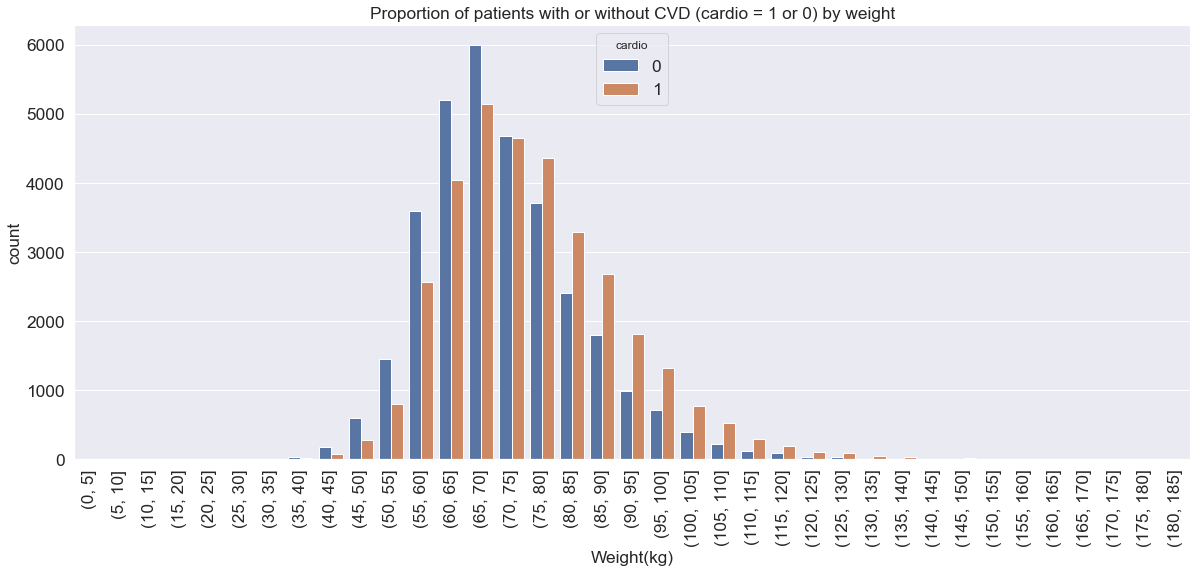

In [89]:
# set plot size
plt.figure(figsize = (20,8))

# set bins
bins = list(np.arange(0,190, 5))
aux1 = df5[['weight', 'cardio']]
aux1['weight'] = pd.cut(aux1['weight'], bins = bins)

#set plot
sns.countplot(hue = 'cardio', x = 'weight', data = aux1)
plt.title('Proportion of patients with or without CVD (cardio = 1 or 0) by weight')
plt.xticks(rotation = 90)
plt.xlabel("Weight(kg)")

# display barplot
plt.show()

### H3. The proportion of CVD cases surpass of non-CVD cases in patients aged 50 or above.
**FALSE**: Proportion of patients with CVD surpass the proportion of non-CVD cases after the 54-year mark. Also, CVD cases reach a peak in the 56-year mark. 

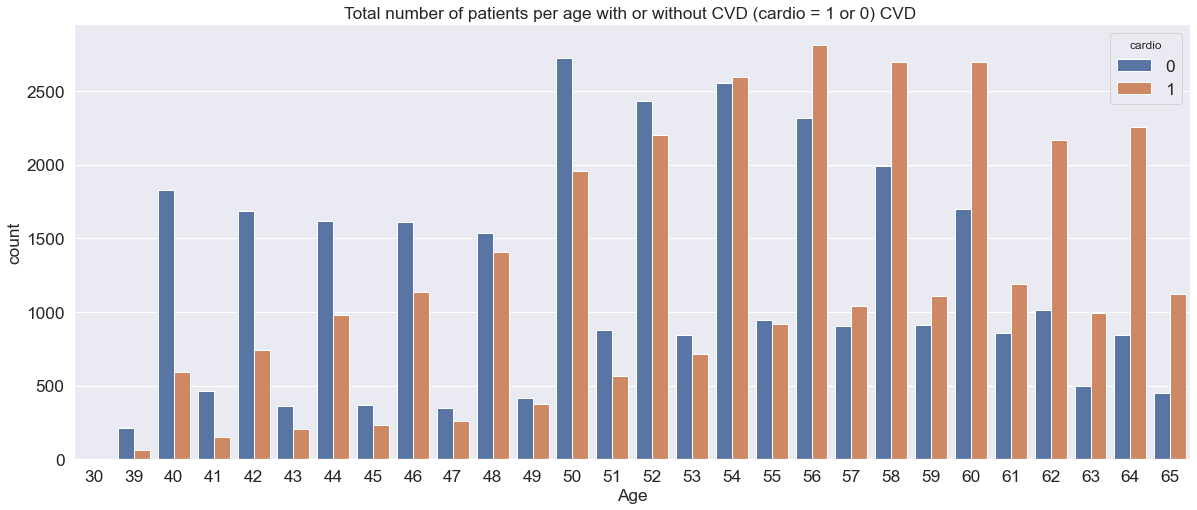

In [88]:
# set plot size
plt.figure(figsize = (20,8))
# set plot
sns.countplot(x = 'age', hue = 'cardio', data = df5)
plt.xlabel("Age")
plt.title('Total number of patients per age with or without CVD (cardio = 1 or 0) CVD ')
# display barplot
plt.show()

### H4. The average height among patients with CVD and without CVD is different with a confidence interval of 95%
**TRUE**: Average height among patients with CVD and without CVD is different.


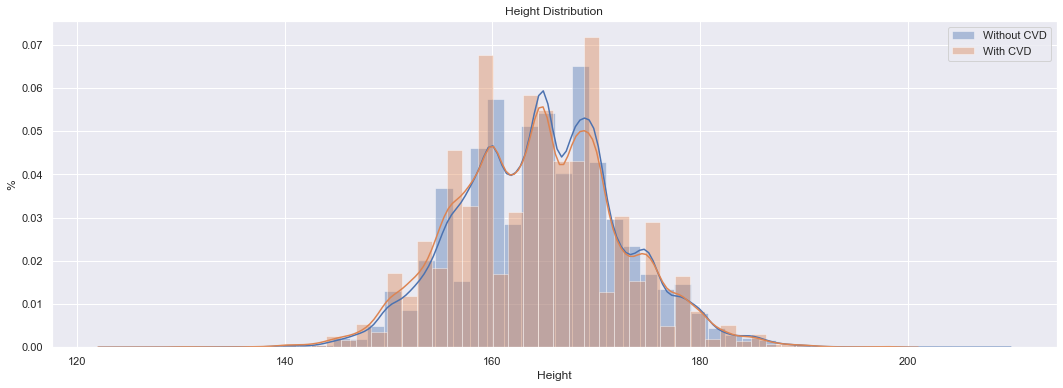

In [67]:
# set plot size
plt.figure(figsize = (18,6))

# set plot 
sns.distplot( df5[df5['cardio'] == 0]['height'], label='Without CVD')
sns.distplot( df5[df5['cardio'] == 1]['height'], label='With CVD')
plt.xlabel("Height")
plt.ylabel("%")
plt.title('Height Distribution');
plt.legend()
plt.show()

![]('https://miro.medium.com/max/466/1*1ZUnA4eR5J2WEGhDVPDkEw.png')

Seems like height distributions are somewhat similar. Let's run an two independent sample t-test with the following hypothesis:    
    
    Null Hypothesis HO: µa = µb (the height means are equal)
    Alternate Hypothesis H1: µa ≠ µb (the height means are not equal) 
    
If we reject the null hypothesis, it means that height is not statistically significant to determine CVD incidence for this dataset.

In [91]:
# separating patients with and without CVD
without_cvd = df5[df5['cardio'] == 0]['height'].to_list()
with_cvd = df5[df5['cardio'] == 1]['height'].to_list()

# calculating confidence interval for sample of patients' height with CVD
confidence_level = 0.95
degrees_freedom = len(with_cvd) - 1
sample_mean = np.mean(with_cvd)
sample_standard_error = stats.sem(with_cvd)
CI = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = stats.ttest_ind(with_cvd,without_cvd)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean Height for patients without CVD = " + str(np.mean(without_cvd)))

t-test = -5.714301329740515
p-value = 1.1063222098253118e-08
Confidence Interval (95%) = (164.28041066675817, 164.4514937075447)
Mean Height for patients without CVD = 164.71630744456832


The p-value is way lower than the alpha value (0.05), and the mean height for patients without CVD is not in between the confidence interval. Therefore, we reject the null hypothesis, which means that height is relevant to determine whether a patient has a CVD or not.

### H5. More than 70% of patients with CVD are patients who smoke.
**FALSE**: More than 80% of patients with CVD don't smoke. However, vast majority of patients in this dataset are non-smokers, which explains the result.

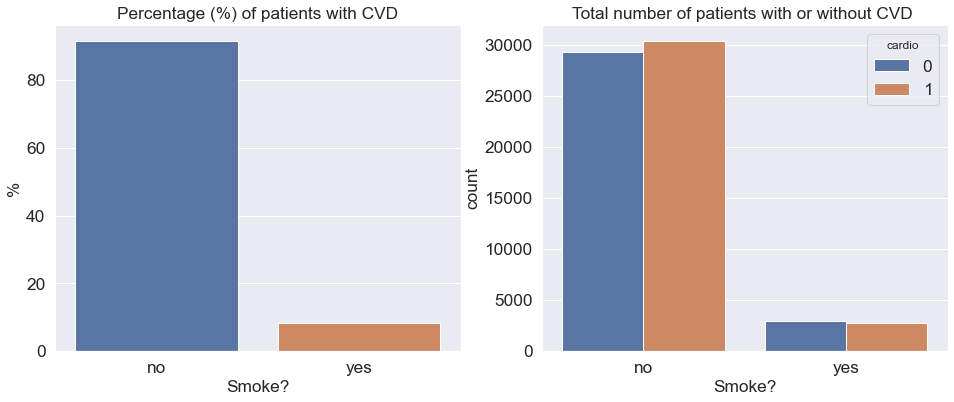

In [118]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['smoke','cardio']].groupby('smoke').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'smoke', y = 'cardio', data = aux2)
plt.xlabel("Smoke?")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'smoke', hue = 'cardio', data = cat_feat)
plt.xlabel("Smoke?")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H6. More than 70% of patients with CVD are physically inactive.
**FALSE**: More than 70% of patients with CVD are physically active. However, vast majority of patients in this dataset are physically active, which explains the result.

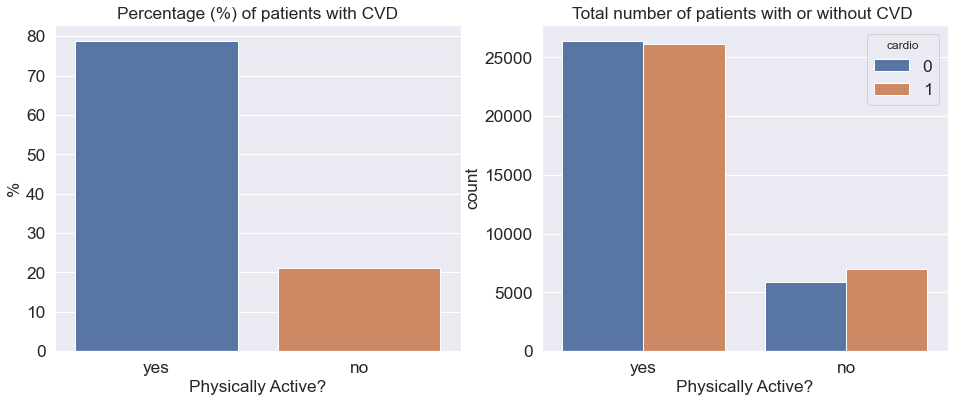

In [160]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['active','cardio']].groupby('active').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'active', y = 'cardio', data = aux2,  order = aux2.sort_values('cardio',ascending = False)['active'].to_list())
plt.xlabel("Physically Active?")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'active', hue = 'cardio', data = cat_feat, order = aux2.sort_values('cardio',ascending = False)['active'].to_list())
plt.xlabel("Physically Active?")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H7. More than 70% of patients with CVD are under the "well above" glucose level category.
**TRUE**: More than 80% of patients with CVD have well above glucose levels. However, vast majority of patients in this dataset are under this category, which explains the result.

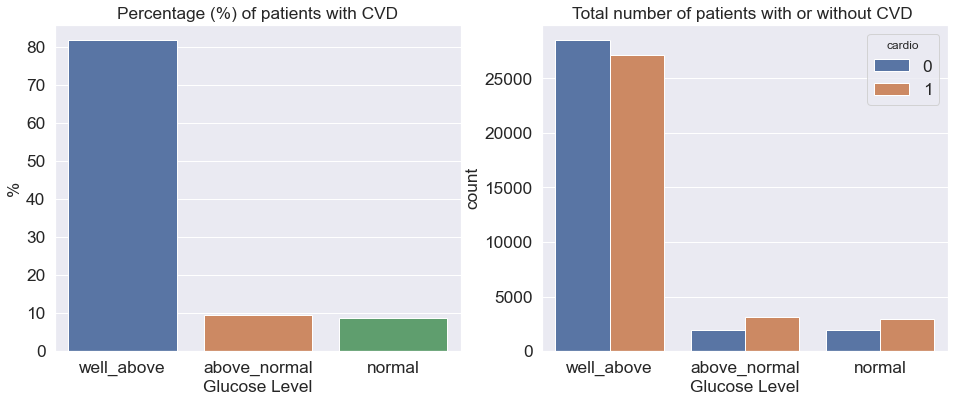

In [159]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['gluc','cardio']].groupby('gluc').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'gluc', y = 'cardio', data = aux2, order = aux2.sort_values('cardio',ascending = False)['gluc'].to_list() )
plt.xlabel("Glucose Level")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'gluc', hue = 'cardio', data = cat_feat,  order = aux2.sort_values('cardio',ascending = False)['gluc'].to_list())
plt.xlabel("Glucose Level")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H8. At least 30% of patients with CVD are patients who drink alcohol.
**FALSE**: Patients with CVD who consume alcohol are minimum (less than 10%). However, vast majority of patients in this dataset don't consume alcohol, which explains the result.

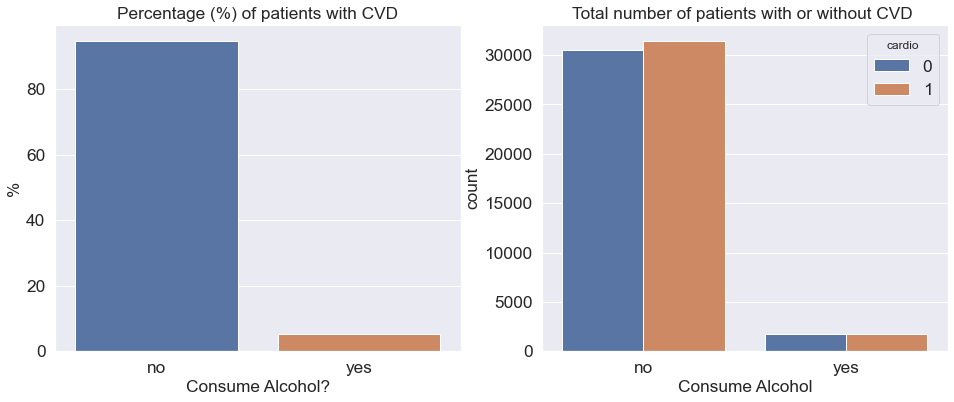

In [121]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['alco','cardio']].groupby('alco').count()/len(aux1)*100).reset_index()

# set plot
sns.barplot(x = 'alco', y = 'cardio', data = aux2)
plt.xlabel("Consume Alcohol?")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

#set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'alco', hue = 'cardio', data = cat_feat)
plt.xlabel("Consume Alcohol")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H9. At least 30% of patients with CVD are under the "well above" cholesterol level category.
**TRUE**: More than 70% of patients with CVD are under this category. However, vast majority of patients in this dataset have well above cholesterol levels.

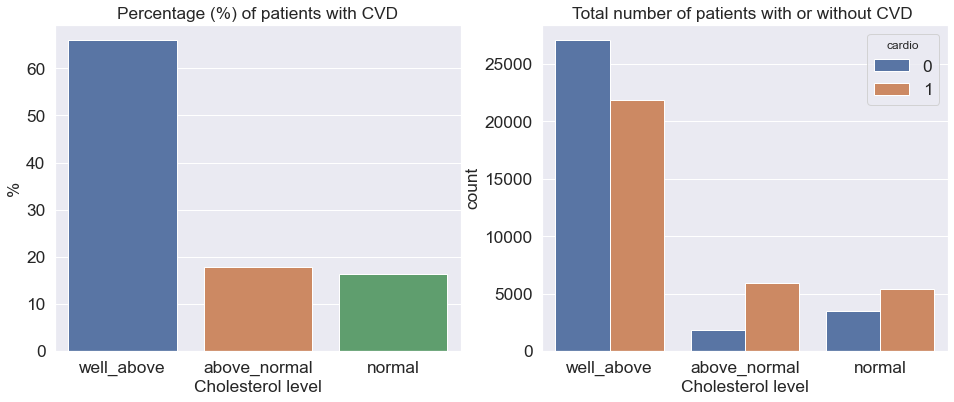

In [158]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['cholesterol','cardio']].groupby('cholesterol').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'cholesterol', y = 'cardio', data = aux2, order = aux2.sort_values('cardio',ascending = False)['cholesterol'].to_list())
plt.xlabel("Cholesterol level")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'cholesterol', hue = 'cardio', data = cat_feat, order = aux2.sort_values('cardio',ascending = False)['cholesterol'].to_list())
plt.xlabel("Cholesterol level")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H10. The average BMI among patients with CVD and without CVD is different with a confidence interval of 95%
**TRUE**: Average BMI among patients is different. BMI is relevant to determine CVD cases.

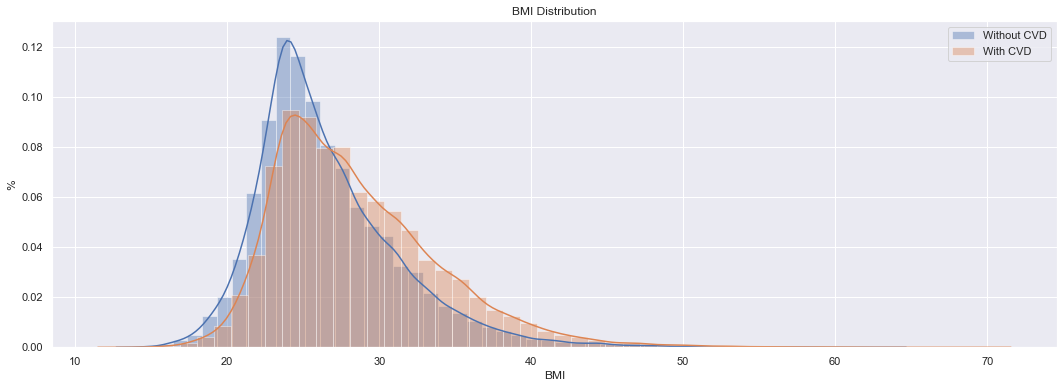

In [66]:
# set plot size
plt.figure(figsize = (18,6))

# set plot 
sns.distplot( df5[df5['cardio'] == 0]['bmi'], label='Without CVD')
sns.distplot( df5[df5['cardio'] == 1]['bmi'], label='With CVD')
# sns.pairplot(df5, x_vars = 'height', hue = 'cardio')
plt.xlabel("BMI")
plt.ylabel("%")
plt.title('BMI Distribution');
plt.legend()
plt.show()

In [89]:
# separating patients with and without CVD
without_cvd = df5[df5['cardio'] == 0]['bmi'].to_list()
with_cvd = df5[df5['cardio'] == 1]['bmi'].to_list()

# calculating confidence interval for sample of patients' height with CVD
confidence_level = 0.90
degrees_freedom = len(with_cvd) - 1
sample_mean = np.mean(with_cvd)
sample_standard_error = stats.sem(with_cvd)
CI = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
t2, p2 = stats.ttest_ind(with_cvd,without_cvd, equal_var = False)
print("t-test = " + str(t2))
print("p-value = " + str(p2))
print("Confidence Interval (95%) = " + str(CI))
print("Mean Height for patients without CVD = " + str(np.mean(without_cvd)))

t-test = 48.26856953333099
p-value = 0.0
Confidence Interval (95%) = (28.438255249756967, 28.53619205163216)
Mean Height for patients without CVD = 26.569734749282524


The p-value is very close to zero and lower than the alpha value (0.05). Since the mean BMI for patients without CVD is not in between the confidence interval, we reject the null hypothesis. BMI is relevant to determine whether a patient has a CVD or not.

### H11. More than 50% of patients with CVD have hypertension (Grade 1 Hypertension or above)
**TRUE**: More than 50% of patients with CVD have hypertension. CVD Patients without hypertension make up for \~43% of the dataset. Among patients without CVD, the proportion of hypertensive patients are lower than non-hypertensive patients.

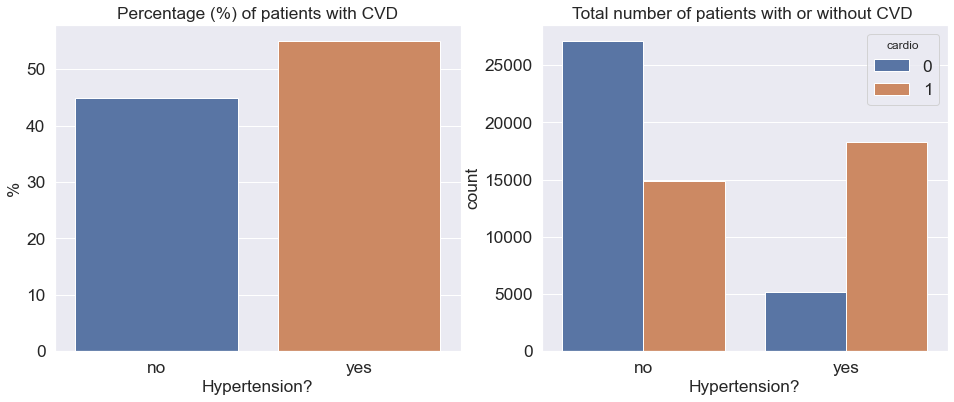

In [157]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['hyper','cardio']].groupby('hyper').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'hyper', y = 'cardio', data = aux2)
plt.xlabel("Hypertension?")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'hyper', hue = 'cardio', data = cat_feat)
plt.xlabel("Hypertension?")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

### H12. More than 70% of patients with CVD have a CVD Risk Scale of "high" or above.
**FALSE**: "High" and "very high" CVD risk patients make up for less than 10% of patients with CVD. "Very low" and "low" CVD risk patients make up for more than 70%. However, vast majority of patients in this dataset are within the "Very low" and "low" CVD risk categories, which explains the result.

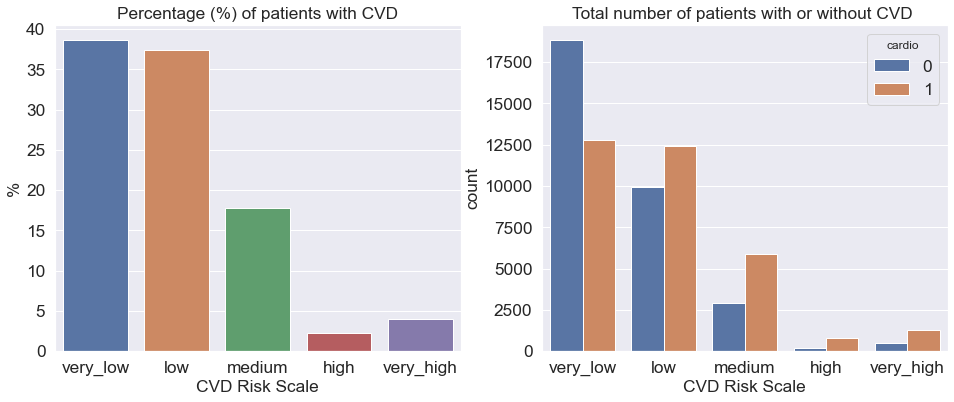

In [171]:
# set plot size
plt.figure(figsize = (16,6))

# set plot position
plt.subplot(121)
# select dataset of patients with CVD
aux1 = cat_feat[cat_feat['cardio'] == 1]
# aggregate data
aux2 = (aux1[['cvd_risk','cardio']].groupby('cvd_risk').count()/len(aux1)*100).reset_index()
# set plot
sns.barplot(x = 'cvd_risk', y = 'cardio', data = aux2, order = ['very_low', 'low', 'medium', 'high', 'very_high'])
plt.xlabel("CVD Risk Scale")
plt.ylabel("%")
plt.title('Percentage (%) of patients with CVD')

# set plot position
plt.subplot(122)
# set plot
sns.countplot(x = 'cvd_risk', hue = 'cardio', data = cat_feat, order = ['very_low', 'low', 'medium', 'high', 'very_high'])
plt.xlabel("CVD Risk Scale")
plt.title('Total number of patients with or without CVD ')
# display barplot
plt.show()

## 4.3. Multivariate Analysis

In this section, we will explore the correlation between variables in the dataset. Since we have several types of variables, we will utilize the three different correlation tests for the following variables:

1. Pearson-Correlation between continuous variables:
    - `age`
    -`height`
    -`weight`
    -`ap_hi`
    -`ap_lo`
    -`bmi`

2. Point-biserial Correlation between continuous variables and the binary target variable `cardio`:
    - `age`
    -`height`
    -`weight`
    -`ap_hi`
    -`ap_lo`
    -`bmi`

2. Cramér's V Correlation between categorical variables and the binary target variable `cardio`:
    - `gender`
    - `cholesterol`
    - `gluc`
    - `smoke`
    - `alco`
    - `active_scale`
    - `cardio`
    - `hyper`
    - `cvd_risk`
    - `bmi_class_enc` 
    - `systolic`
    - `diastolic`
    - `sys_diast`

Pearson and Point-Biserial Correlations will be shown in the same heatmap, while Cramér's V Correlation will be displayed in a different one.

In [49]:
# encoding systolic, diastolic, and sys_diast variables for correlation test

df5['systolic'] = df5['systolic'].apply(lambda x: 0 if x == 'normal'
                                       else 1 if x == 'high_normal'
                                       else 2 if x == 'grade_1'
                                       else 3 if x == 'grade_2'
                                       else 4)
df5['diastolic'] = df5['diastolic'].apply(lambda x: 0 if x == 'normal'
                                       else 1 if x == 'high_normal'
                                       else 2 if x == 'grade_1'
                                       else 3 if x == 'grade_2'
                                       else 4)
df5['sys_diast'] = df5['sys_diast'].apply(lambda x: 0 if x == 'normal'
                                       else 1 if x == 'high_normal'
                                       else 2 if x == 'grade_1'
                                       else 3 if x == 'grade_2'
                                       else 4)
# select numerical variables to run Pearson correlation test
num_feat = df5[['age','height','weight','ap_hi','ap_lo','bmi']]
# select binary variables to run Point biserial correlation test
bin_feat = df5[['gluc','smoke','alco','active_scale','cardio','hyper']]
# select categorical variables to run Cramér's V test
cat_feat = df5[['gender','cholesterol','gluc','smoke','alco','active_scale',
                'cardio','hyper','cvd_risk','bmi_class_enc', 
                'systolic','diastolic','sys_diast']]

### 5.3.1. Continuous Variables vs Target Variable

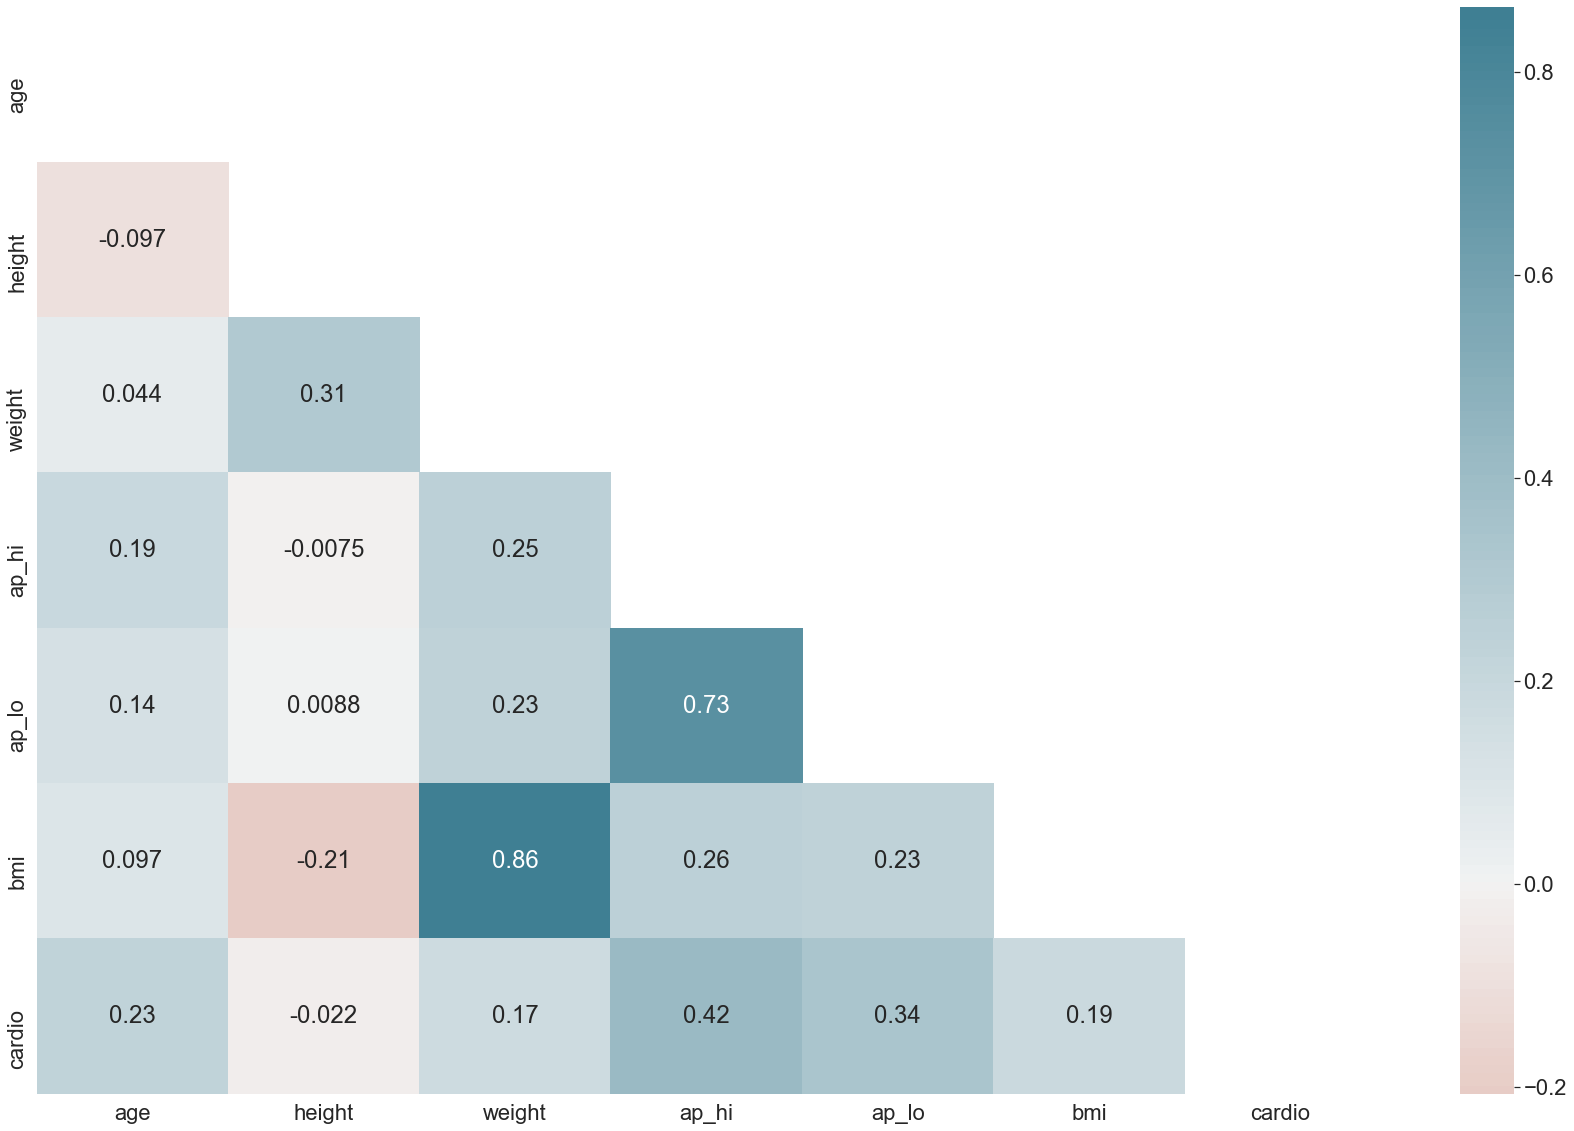

In [50]:
# retrieve pearson correlations into a dataframe
df_corr = num_feat.corr(method = 'pearson')

# retrieve point-biserial correlations and add them to dataframe
cardio = []
for k, n in enumerate(num_feat.columns):
    ak = stats.pointbiserialr(num_feat[f'{n}'], bin_feat['cardio'])[0]
    cardio.append(ak)
    if k == 5:
        df_corr.loc['cardio'] = cardio
        cardio.append(1)
df_corr['cardio'] = cardio

## Plot fig sizing. 
style.use('ggplot')
sns.set(font_scale=2)
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))

## Plotting heatmap. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,cmap=sns.diverging_palette(20, 220, n=200),mask = mask,annot=True, 
            center = 0,);

In this heatmap, correlation between continuous variables were computed by the pearson correlation method, while correlation between the target variable `cardio` and continuous variables were calculated by the point-biserial correlation method.

**Highlights**:
- Strong positive correlation between **weight** and **bmi**, **systolic (ap_hi)** and **diastolic (ap_lo)**;
- Weak but negative correlation between **height** and **bmi**;
- The target variable `cardio` has a mild positive correlation with **systolic (ap_hi)** and **diastolic (ap_lo)**, an almost zero correlation with **height**, and weak positive correlations with other variables;
- Almost zero correlation between **bmi** and **age**, **weight** and **age**, **diastolic (ap_lo)** and **height**, **systolic (ap_hi)** and **height**.

### 5.3.2. Categorical Variables vs Target Variable

Text(0.5, 1.0, "Cramér's V")

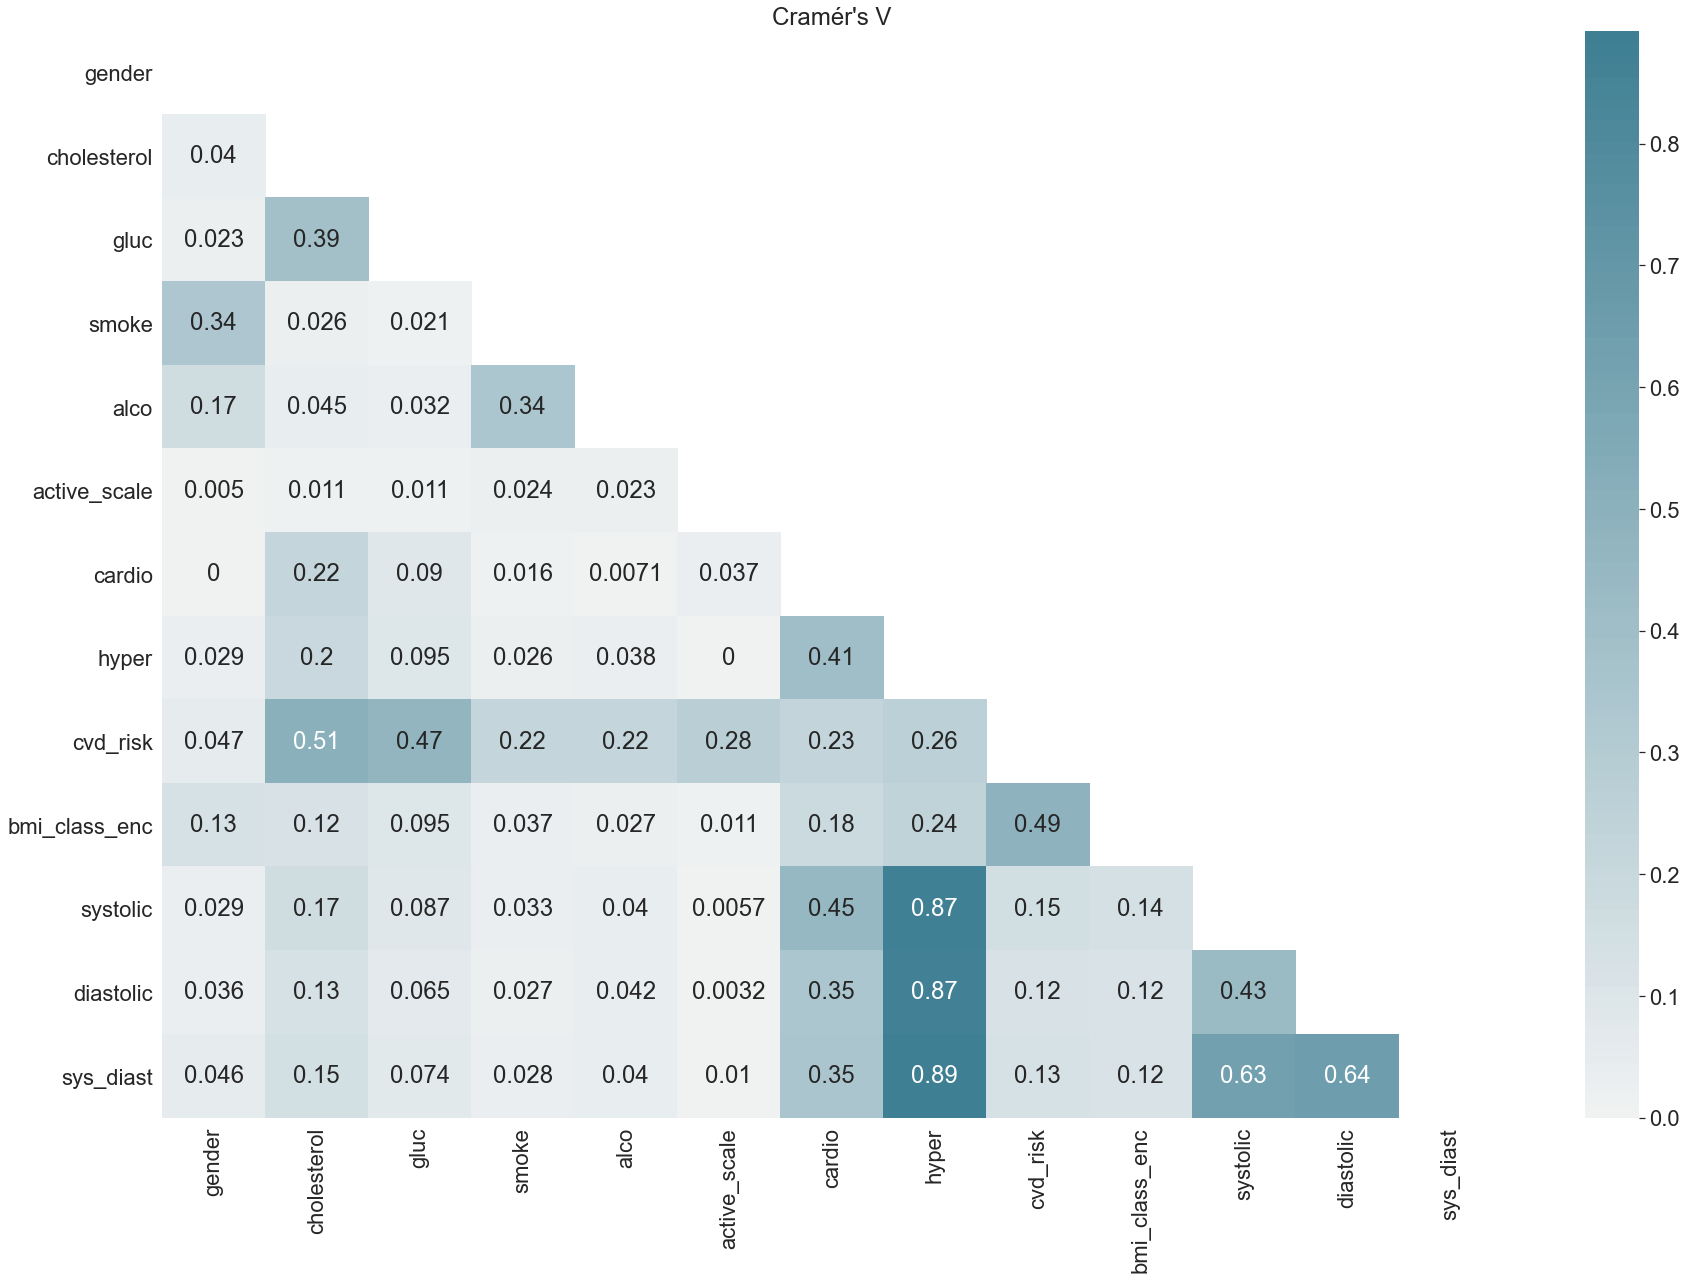

In [51]:
# calculate cramer_V values
cramer = []
for k, n in enumerate(cat_feat.columns):
    for d, l in enumerate(cat_feat.columns):
        ad = cramer_v(cat_feat[f'{n}'], cat_feat[f'{l}'])
        cramer.append(ad)

# assign cramer_V values as a dictionary
d = 0
df_cramer = dict()
for n in cat_feat.columns:
    df_cramer[f'{n}'] = cramer[d:d+13]
    d += 13

# set dataframe 
df_cramer_v = pd.DataFrame(df_cramer, index=cat_feat.columns.to_list())
## Plot fig sizing. 
style.use('ggplot')
sns.set(font_scale=2)
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))

## Plotting heatmap. 
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_cramer_v, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_cramer_v,cmap=sns.diverging_palette(20, 220, n=200),mask = mask,annot=True, 
            center = 0,)
plt.title('Cramér\'s V')

**Highlights**:
- Strong positive correlation between **hyper** and **sys_diast**, **hyper** and **diastolic **,  **hyper** and **systolic**;
- Mild positive correlation between **sys_diast** and **diastolic**, **sys_diast** and **systolic **, **diastolic** and **systolic** **cvd_risk** and **bmi_class_enc**,  **cvd_risk** and **cholesterol**,  **cvd_risk** and **gluc**,  **smoke** and **gender**,  **cholesterol** and **gluc**,  **alco** and **gluc**;
- The target variable `cardio` has a mild positive correlation with **systolic**, **diastolic**, **sys_diast**, and **hyper**. 
- The target variable `cardio` has a weak positive correlation with **bmi_class_enc**, **cholesterol**, and **cvd_risk**. 
- The target variable `cardio` has a zero or almost zero correlation with **gender**, **gluc**, **smoke**, **alco**, and **active_scale**. 

# 5.0. STEP 05 - DATA PREPROCESSING

In [52]:
# # Save Step 05 data
# pickle.dump( df5, open( 'data\df5.pkl', 'wb' ) )

# Load Step 02 data
df6 = pickle.load(open ('data\df5.pkl', 'rb'))

## 5.1. Drop unnecessary columns and saving IDs

In [53]:
# save id column
id_column = df6['id']

# drop unnecessary columns
df6 = df6.drop(['id','bmi_class','active_scale'], axis = 1)

## 5.2. Split dataset into train, validation, and test (67/12/20)

In [54]:
# Split target variables and features
X = df6.drop('cardio', axis = 1).copy()
y = df6[['cardio']].copy()

In [55]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# check balance of classes (0, 1) among y_train and y_test.
print(f"Class size for train dataset: {np.bincount(y_train['cardio'])}")
print(f"Class size for test dataset: {np.bincount(y_test['cardio'])}")

Class size for train dataset: [25833 26537]
Class size for test dataset: [6459 6634]


In [56]:
# train valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# check balance of classes (0, 1) among y_train and y_test.
print(f"Class size for train dataset: {np.bincount(y_train['cardio'])}")
print(f"Class size for valid dataset: {np.bincount(y_valid['cardio'])}")

Class size for train dataset: [22030 22484]
Class size for valid dataset: [3803 4053]


In [57]:
print(f'X_train dataset: {X_train.shape[0]} columns, {X_train.shape[1]} rows')
print(f'y_train dataset: {y_train.shape[0]} rows')
print(f'X_test dataset: {X_test.shape[0]} columns, {X_test.shape[1]} rows')
print(f'y_test dataset: {y_test.shape[0]} rows')
print(f'X_valid dataset: {X_valid.shape[0]} columns, {X_valid.shape[1]} rows')
print(f'y_valid dataset:{y_valid.shape[0]} rows')

X_train dataset: 44514 columns, 18 rows
y_train dataset: 44514 rows
X_test dataset: 13093 columns, 18 rows
y_test dataset: 13093 rows
X_valid dataset: 7856 columns, 18 rows
y_valid dataset:7856 rows


## 5.3. Categorical Encoding


To select the best encoder for each variable, two things need to be checked:
1. **Presence/absence of state**: gender, smoke, alco, active, hyper. Since these variables are binary ones indicating state, we will use **the One-hot Encoding**.
2. **Order of categories**: cholesterol, gluc, systolic, diastolic, sys_diast, bmi_class_enc, cvd_risk. Here we could have used an encoder that captures the frequency relationship between classes; however, each class has more relevancy in terms of order than frequency. Since we have already applied **the Ordinal Encoding method** in these variables, we will leave them as they are.

In [58]:
# One-hot Encoding
one_hot = ['gender','smoke','alco','active','hyper']
for n in one_hot:
    X_train = pd.get_dummies(X_train, prefix = [f'{n}'], columns = [f'{n}'])
    X_valid = pd.get_dummies(X_valid, prefix = [f'{n}'], columns = [f'{n}'])
    X_test = pd.get_dummies(X_test, prefix = [f'{n}'], columns = [f'{n}'])

print(f'X_train dataset: {X_train.shape[0]} columns, {X_train.shape[1]} rows')
print(f'y_train dataset: {y_train.shape[0]} rows')
print(f'X_valid dataset: {X_valid.shape[0]} columns, {X_valid.shape[1]} rows')
print(f'y_valid dataset: {y_valid.shape[0]} rows')
print(f'X_test dataset: {X_test.shape[0]} columns, {X_test.shape[1]} rows')
print(f'y_test dataset: {y_test.shape[0]} rows')

X_train dataset: 44514 columns, 23 rows
y_train dataset: 44514 rows
X_valid dataset: 7856 columns, 23 rows
y_valid dataset: 7856 rows
X_test dataset: 13093 columns, 23 rows
y_test dataset: 13093 rows


## 5.4. Rescaling Numerical Variables

Before we select a rescaling method for numerical variables, we need to re-examine the variable's boxplots and distribution for the training dataset.

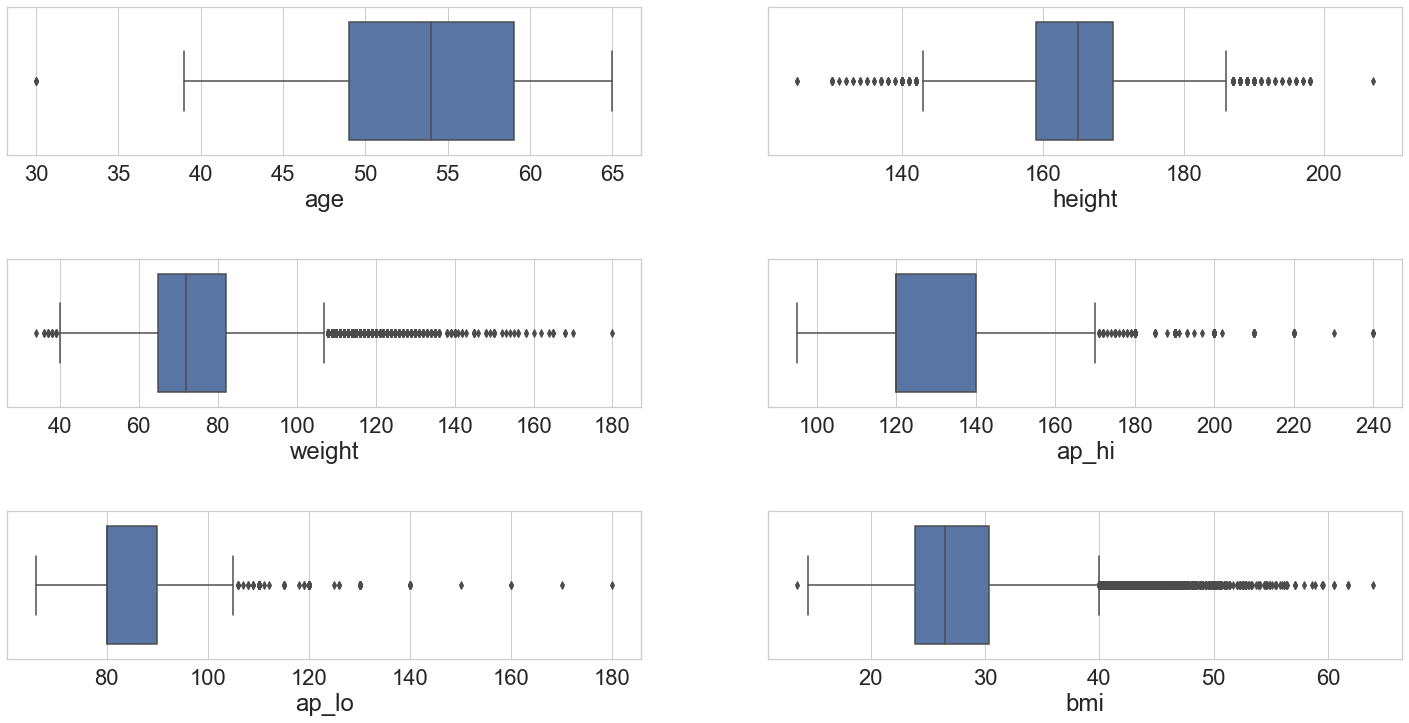

In [59]:
# analyzing box plots
num_var = ['age','height','weight','ap_hi','ap_lo','bmi']
X_train[num_var].columns.to_list()
for k, n in enumerate(X_train[num_var].columns.to_list()):
    plt.subplot(3,2,k+1)
    sns.boxplot(X_train[f'{n}'])
    plt.subplots_adjust(hspace=0.7)
    plt.subplots_adjust(wspace=0.2)

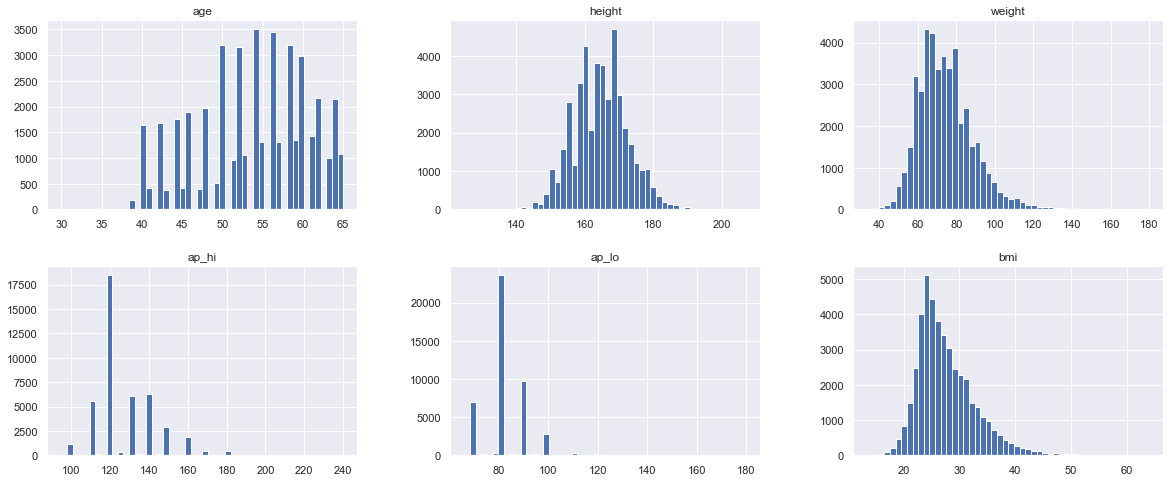

In [25]:
# analyzing distributions
num_var = X_train[num_var]
num_var.hist(bins = 50, figsize = (20,8), layout = (2,3));

Seems like the variables have some profusion of outliers in the train dataset. **We will use the RobustScaler method** to reshape them.

In [41]:
# set rescaling methods
rs = RobustScaler()
# age
rs_age = rs.fit(X_train[['age']].values)
rs_age_test = rs.fit(X_test[['age']].values)
X_train['age'] = rs_age.transform(X_train[['age']].values)
X_valid['age'] = rs_age.transform(X_valid[['age']].values)
X_test['age'] = rs_age_test.transform(X_test[['age']].values)

# height
rs_height = rs.fit(X_train[['height']].values)
rs_height_test = rs.fit(X_test[['height']].values)
X_train['height'] = rs_height.transform(X_train[['height']].values)
X_valid['height'] = rs_height.transform(X_valid[['height']].values)
X_test['height'] = rs_height_test.transform(X_test[['height']].values)

# weight
rs_weight = rs.fit(X_train[['weight']].values)
rs_weight_test = rs.fit(X_test[['weight']].values)
X_train['weight'] = rs_weight.transform(X_train[['weight']].values)
X_valid['weight'] = rs_weight.transform(X_valid[['weight']].values)
X_test['weight'] = rs_weight_test.transform(X_test[['weight']].values)

# ap_hi
rs_aphi = rs.fit(X_train[['ap_hi']].values)
rs_aphi_test = rs.fit(X_test[['ap_hi']].values)
X_train['ap_hi'] = rs_aphi.transform(X_train[['ap_hi']].values)
X_valid['ap_hi'] = rs_aphi.transform(X_valid[['ap_hi']].values)
X_test['ap_hi'] = rs_aphi_test.transform(X_test[['ap_hi']].values)

# ap_lo
rs_aplo = rs.fit(X_train[['ap_lo']].values)
rs_aplo_test = rs.fit(X_test[['ap_lo']].values)
X_train['ap_lo'] = rs_aplo.transform(X_train[['ap_lo']].values)
X_valid['ap_lo'] = rs_aplo.transform(X_valid[['ap_lo']].values)
X_test['ap_lo'] = rs_aplo_test.transform(X_test[['ap_lo']].values)

# bmi
rs_bmi = rs.fit(X_train[['bmi']].values)
rs_bmi_test = rs.fit(X_test[['bmi']].values)
X_train['bmi'] = rs_bmi.transform(X_train[['bmi']].values)
X_valid['bmi'] = rs_bmi.transform(X_valid[['bmi']].values)
X_test['bmi'] = rs_bmi.transform(X_test[['bmi']].values)


# 6.0. STEP 06 - FEATURE SELECTION

We will use **Boruta** and **Recursive Feature Elimination (RFE)** methods to check whether we can use the selected features provided by them to our model.

In [60]:
# Save Step 06 data
# pickle.dump( X_train, open( 'data\X_train.pkl', 'wb' ) )
# pickle.dump( X_test, open( 'data\X_test.pkl', 'wb' ) )
# pickle.dump( X_valid, open( 'data\X_valid.pkl', 'wb' ) )
# pickle.dump( y_train, open( 'data\y_train.pkl', 'wb' ) )
# pickle.dump( y_test, open( 'data\y_test.pkl', 'wb' ) )
# pickle.dump( y_valid, open( 'data\y_valid.pkl', 'wb' ) )

# Load Step 06 data
X_train = pickle.load(open ('data\X_train.pkl', 'rb'))
X_valid = pickle.load(open ('data\X_valid.pkl', 'rb'))
y_train = pickle.load(open ('data\y_train.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))


## 7.1. Boruta

Boruta has selected only the variables `ap_hi` and `bmi` as relevant to the model. Since many relevant variables weren't selected, we won't use Boruta suggestions.

In [278]:
# transforming training and validation dataset into numpy array
X_train_n = X_train.values
y_train_n = y_train.values.ravel() # ravel flattens all numbers into a 1-D array

# Model to be used on boruta
rf = RandomForestClassifier(n_jobs = -1)

# Defining Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n) 
# 'auto' = automatic selection of # trees, 'verbose' = plotting each step

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	20
I

In [279]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, cols_selected_boruta ) )

In [280]:
# display selected features
pd.DataFrame(cols_selected_boruta)

,0
0,ap_hi
1,bmi


In [281]:
# display not selected features
pd.DataFrame(cols_not_selected_boruta)

,0
0,active_0
1,active_1
2,age
3,alco_0
4,alco_1
5,ap_lo
6,bmi_class_enc
7,cholesterol
8,cvd_risk
9,diastolic


## 7.2. Recursive Feature Elimination (RFE)

Columns `age`, `height`, `weight`, `ap_hi` were selected by the RFE. Since only `ap_hi` appeared in both RFE and Boruta, and many other relevant variables were excluded by both feature selectors, their recommendation won't be followed.

In [286]:
# Model to be used on RFE
rf = RandomForestClassifier(n_jobs = -1)
# fit model
rfe = RFE(rf, n_features_to_select=5)
fit = rfe.fit(X_train, y_train)

# summarize all features
for i in range(X_train.shape[1]):
	print('Column: {}, Selected {}, Rank: {}'.format(X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

Column: age, Selected True, Rank: 1
Column: height, Selected True, Rank: 1
Column: weight, Selected True, Rank: 1
Column: ap_hi, Selected True, Rank: 1
Column: ap_lo, Selected False, Rank: 3
Column: cholesterol, Selected False, Rank: 6
Column: gluc, Selected False, Rank: 11
Column: systolic, Selected False, Rank: 2
Column: diastolic, Selected False, Rank: 13
Column: sys_diast, Selected False, Rank: 10
Column: bmi, Selected True, Rank: 1
Column: bmi_class_enc, Selected False, Rank: 9
Column: cvd_risk, Selected False, Rank: 4
Column: gender_1, Selected False, Rank: 14
Column: gender_2, Selected False, Rank: 8
Column: smoke_0, Selected False, Rank: 15
Column: smoke_1, Selected False, Rank: 18
Column: alco_0, Selected False, Rank: 19
Column: alco_1, Selected False, Rank: 17
Column: active_0, Selected False, Rank: 12
Column: active_1, Selected False, Rank: 16
Column: hyper_0, Selected False, Rank: 7
Column: hyper_1, Selected False, Rank: 5


## 7.3. Feature Importance

Some algorithms have the capability of showing feature importance after we train them. We used the following models to retrieve feature importance:

- **Logistic Regression**: `alco_0`, `active_0`, `cvd_risk`, `ap_lo`, `smoke_0`,`bmi_class_enc`, `gender_1` have almost zero coefficient. Many variables are closer to zero coefficient, so it seems that each variable contributes little to explain the target variable.
- **Random Forest Classifier & Balanced Random Forest Classifier**: `alco_0`, `alco_1`, `smoke_0`, `smoke_1`, `active_0`, `active_1`,  `gender_1`,  `gender_2`, 
 `gluc`, `diastolic`, `sys_diast`,  `bmi_class_enc` have score values very close to zero.
- **CatBoost Classifier**:  `smoke_0`, `smoke_1`,`gender_1`,  `gender_2`,`bmi_class_enc`,`alco_0`,`alco_1`,`diastolic`,`hyper_0`,`hyper_1`,`active_0`, `active_1`, have scores values very close to zero.
- **XGB Classifier**:`diastolic`,`systolic`,`hyper_1`,`alco_1`, `active_1`,`bmi_class_enc`,`smoke_1`,`gender_2`,  have scores values very close to zero.
- **LGBM Classifier**:`diastolic`,`systolic`,`hyper_0`,`hyper_1`,`alco_1`, `active_1`,`bmi_class_enc`,`smoke_1`,`gender_2`,  have scores values very close to zero.

According to the multivariate analysis and the features selected by the algorithms, we would drop the following variables:

- `bmi_class_enc`
- `gender_1`
- `gender_2`
- `smoke_0`
- `smoke_1`
- `alco_0`
- `alco_1`
- `active_0`
- `active_1`

However, we won't drop these variables in this CRISP-DM cycle since the medical literature has shown that there is a correlation between CVDs and these features. In a real situation, we would seek for more data to get robust results, or remove features that has less impact over the target variable such as `bmi_class_enc`,`gender_1`, and `gender_2`.

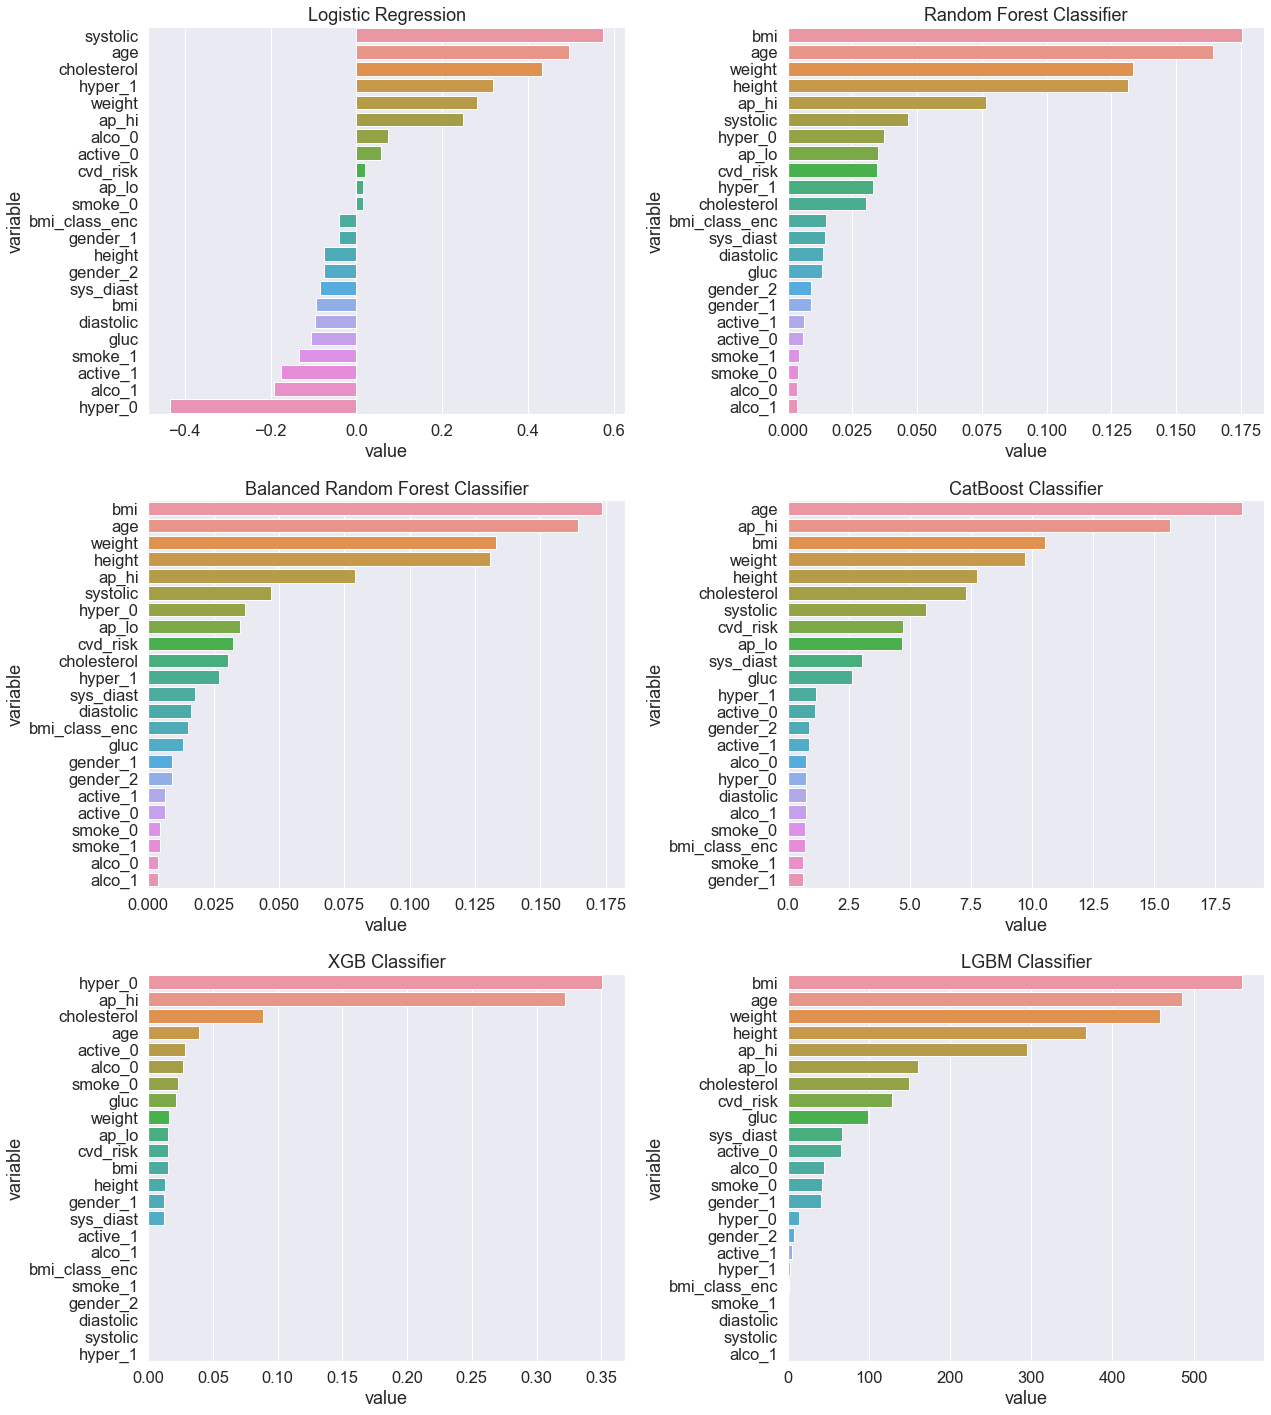

In [518]:
feature_importance(3, 2)

In [61]:
X_train = X_train.drop(['bmi_class_enc','gender_1','gender_2'], axis = 1)
X_valid = X_valid.drop(['bmi_class_enc','gender_1','gender_2'], axis = 1)

# 7.0. STEP 07 - MACHINE LEARNING MODELING

In [4]:
# Load Step 06 data
X_train = pickle.load(open ('data\X_train.pkl', 'rb'))
X_valid = pickle.load(open ('data\X_valid.pkl', 'rb'))
y_train = pickle.load(open ('data\y_train.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))


## 7.1. Interpreting Accuracy Metrics

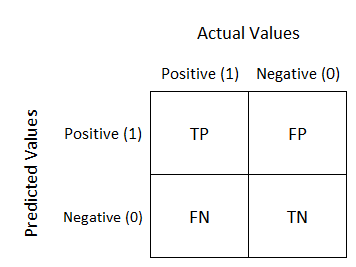

In [128]:
Image('img/confusion.png')

In [163]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, cohen_kappa_score, precision_score, recall_score, roc_curve, balanced_accuracy_score

### 8.1.1. Accuracy

Classification accuracy is our starting point.   
It is the number of correct predictions made divided by the total number of predictions made, multiplied by 100 to turn it into a percentage.  
Accuracy is a baseline metric to evaluate performance of Machine learning models. However, if your data has imbalance problems between classes, accuracy won't tell the whole story and will be not useful to measure performance.

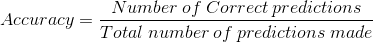

In [126]:
Image('img/accuracy.gif')

In [184]:
accuracy_score(y_valid, y_hat)

0.7287423625254582

### 8.1.2. Precision & Recall

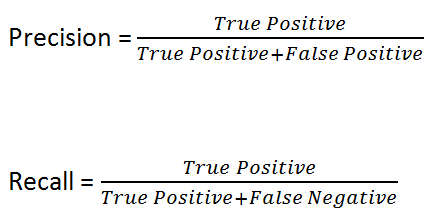

In [127]:
Image('img/pre_rec.png')

Precision is the number of True Positives divided by the number of True Positives and False Positives.   
It is the number of positive predictions divided by the total number of predicted positives.  
**Precision is a good measure when the costs of False Positive (patients without CVD but diagnosed with CVD) is high.**

Recall calculates how many of the True Positives the model capture among all positives in the dataset.   
**Recall is a good measure when there is a high cost associated with False Negatives (patients with CVD but diagnosed without CVD).**

In this project, we have a dual objective: (1) increase diagnostic precision, since the business earn \$500 for each 5% increase on precision in diagnostics; (2) increase recall rate, since it would be very costly for patients with CVD to receive a diagnostic of not having CVD.

### 8.1.3. F1-Score

The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall.  
**F1 Score is needed when you want to seek a balance between Precision and Recall.** In this project case, we need a balance between precision and recall - therefore, the model with higher F1-score would be utilized.

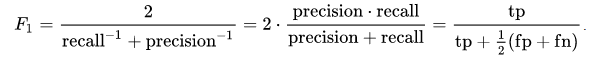

In [135]:
Image('img/f1.png')

### 8.1.5. AUC-ROC Score

ROC or Receiver Operating Characteristic plot is used to visualise the performance of a binary classifier. It gives us the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) at different classification thresholds.  
AUC values range from 0 to 1. The closer to 1, the more accurate predictions a model generates.  
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

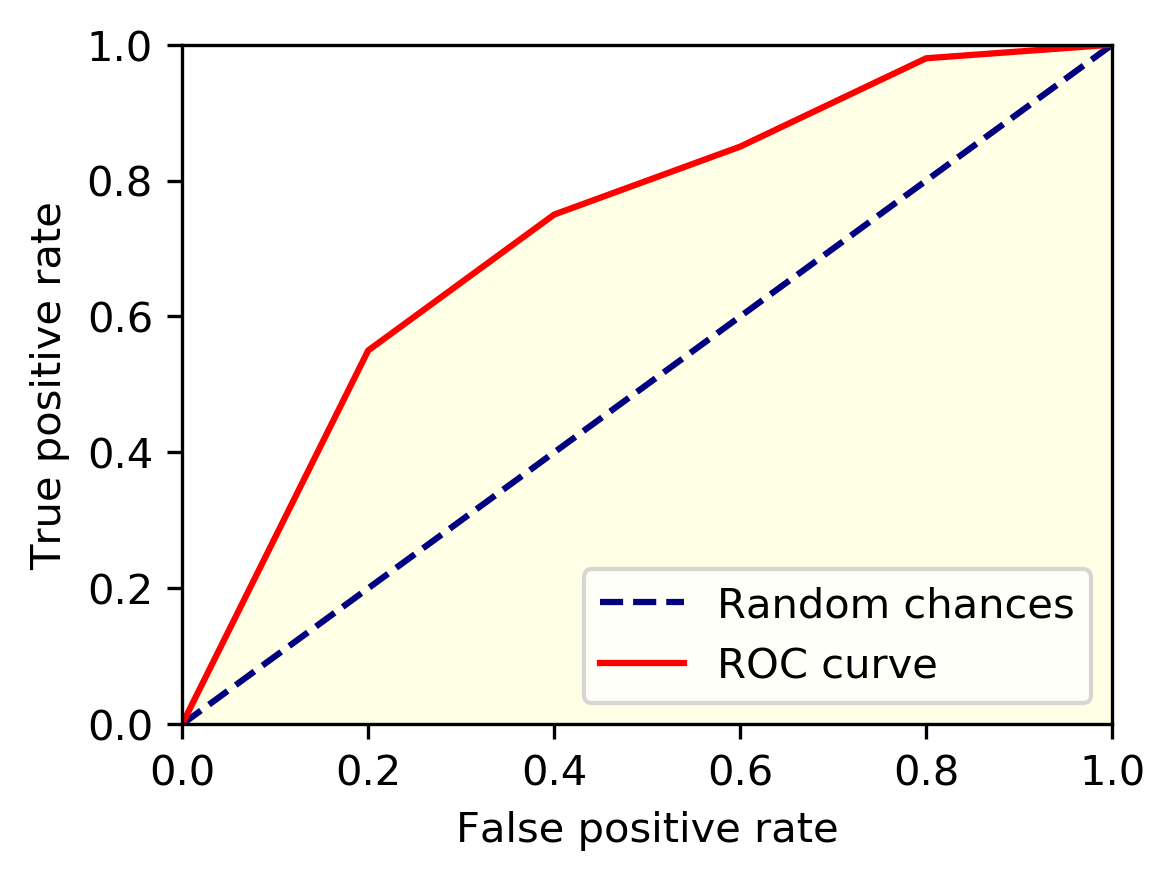

In [161]:
Image('img/roc.png')
#https://towardsdatascience.com/a-simple-explanation-of-the-roc-curve-and-auc-64db32d75541

### 8.1.6. Kappa Score

https://towardsdatascience.com/cohens-kappa-9786ceceab58

### 8.1.7. Brier Score Loss


According to sklearn: 

    The Brier score measures the mean squared difference between (1) the predicted probability assigned to the possible outcomes for item i, and (2) the actual outcome. The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but is inappropriate for ordinal variables which can take on three or more values (this is because the Brier score assumes that all possible outcomes are equivalently “distant” from one another)

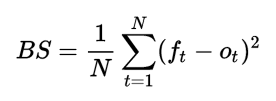

In [234]:
Image('img/brier-score.png')

Where:

    N = the number of items you’re calculating a Brier score for.
    ft is the forecast probability,
    ot is the outcome (1 if it happened, 0 if it didn’t).
    Σ is the summation symbol. It just means to “add up” all of the values.


    
StatisticsHowTo:   
    
    The best possible Brier score is 0, for total accuracy.
    The lowest possible score is 1, which mean the forecast was wholly inaccurate.


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html  
https://www.statisticshowto.com/brier-score/

## 7.2. Modeling

https://analyticsindiamag.com/7-types-classification-algorithms/

Since both precision and recall metrics are important for the business, the F1 score will be used as the main criteria to select the right model for this project. The remnant scores will also be checked for the sake of completeness, although the Brier Score will be the second most important metric to be checked after F1 score.     
From the results below, three models have similar F1, precision, recall, and Brier scores: **CatBoost Classifier, XGB Classifier, and LGBM Classifier**.

In [40]:
# setting probability threshold for models
threshold = 0.45

# define algorithms
models = [CatBoostClassifier(random_state=42, verbose=False),
          XGBClassifier(random_state=42),
          LGBMClassifier(random_state=42, n_jobs=-1),
          LogisticRegression(max_iter=220, random_state=42),
          RandomForestClassifier(random_state=42),
          BalancedRandomForestClassifier(random_state=42),
          KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1),
          SGDClassifier(loss='log', random_state=42, n_jobs=-1), 
          GaussianNB(),
          svm.SVC(kernel = 'linear', random_state=42)]
ml_performance(models, X_train, y_train, X_valid, y_valid, threshold, 'yes')

Training CatBoostClassifier...
Training XGBClassifier...
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training KNeighborsClassifier...
Training SGDClassifier...
Training GaussianNB...
Training SVC...


,Model Name,Recall,Precision,F1-Score,ROC-AUC,Accuracy,Kappa score,Brier score
0,LGBMClassifier,0.7580,0.7385,0.7481,0.8066,0.7366,0.4723,0.1783
0,CatBoostClassifier,0.7498,0.7416,0.7457,0.8065,0.7361,0.4715,0.1783
0,XGBClassifier,0.7476,0.7378,0.7426,0.8004,0.7327,0.4646,0.1811
0,LogisticRegression,0.7126,0.7535,0.7324,0.8002,0.7314,0.4632,0.1826
0,RandomForestClassifier,0.7506,0.6987,0.7237,0.7685,0.7043,0.4066,0.1997
0,SGDClassifier,0.6827,0.7654,0.7217,0.7966,0.7284,0.4581,0.1842
0,BalancedRandomForestClassifier,0.7414,0.6966,0.7183,0.7686,0.7000,0.3981,0.1999
0,KNeighborsClassifier,0.7276,0.6887,0.7076,0.7396,0.6898,0.3778,0.2244
0,SVC,0.6339,0.7956,0.7056,0.7766,0.7271,0.4572,0.2734
0,GaussianNB,0.6277,0.7683,0.6909,0.7766,0.7103,0.4235,0.2734


## 7.3. Confusion Matrix

The three selected models have similar performance when their confusion matrices are put side by side.

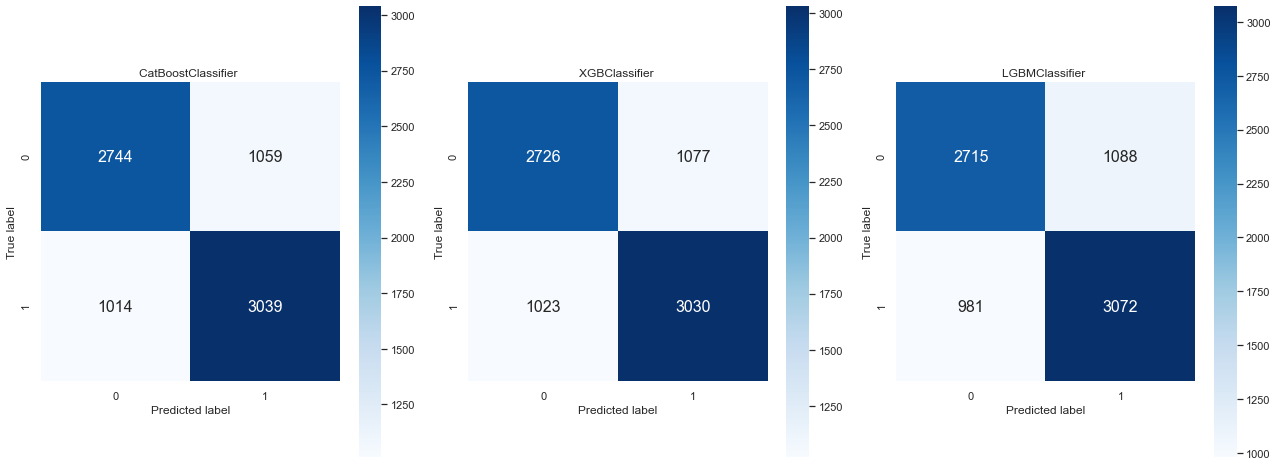

In [41]:
selected_models = [CatBoostClassifier(random_state=42, verbose=False),
          XGBClassifier(random_state=42),
          LGBMClassifier(random_state=42, n_jobs=-1)]

multiple_confusion_matrices(1,3, X_train, y_train, X_valid, y_valid, selected_models, threshold)

## 7.4. Probability Distribution

Although the confusion matrices displayed above give us a good overview over each model's performance, it is also useful to analyze probability distributions across the values 0 (patients who were categorized as without CVD) and 1 (otherwise).  
In general, the LGBM model has more concentrated data around probabilities of value 0 and 1, which means that the model is more assertive than others when assigning probabilities.

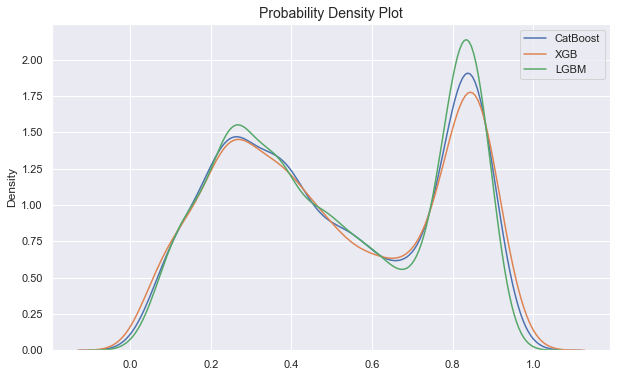

In [42]:
# instantiate the best classifiers
cb_clf = CatBoostClassifier(random_state=42, verbose=False)
xgb_clf = XGBClassifier(random_state=42)
lgbm_clf = LGBMClassifier(random_state=42, n_jobs=-1)

# train classifiers
cb_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)

# store predicted probabilities for class 1 (patient has CVD)
y_pred_cb_prob = cb_clf.predict_proba(X_valid)[:,1]
y_pred_xgb_prob = xgb_clf.predict_proba(X_valid)[:,1]
y_pred_lgbm_prob = lgbm_clf.predict_proba(X_valid)[:,1]

# sets the plot size
plt.figure(figsize=(10,6))

# plots
sns.kdeplot(y_pred_cb_prob, label='CatBoost')
sns.kdeplot(y_pred_xgb_prob, label='XGB')
sns.kdeplot(y_pred_lgbm_prob, label='LGBM')

# sets the plot features
plt.title("Probability Density Plot", fontsize=14)
plt.legend()

# display the plot
plt.show();

## 7.5. ROC Curve

The more outward curved a ROC curve is, the better. In this requisite, **the LGBM is the winner.**

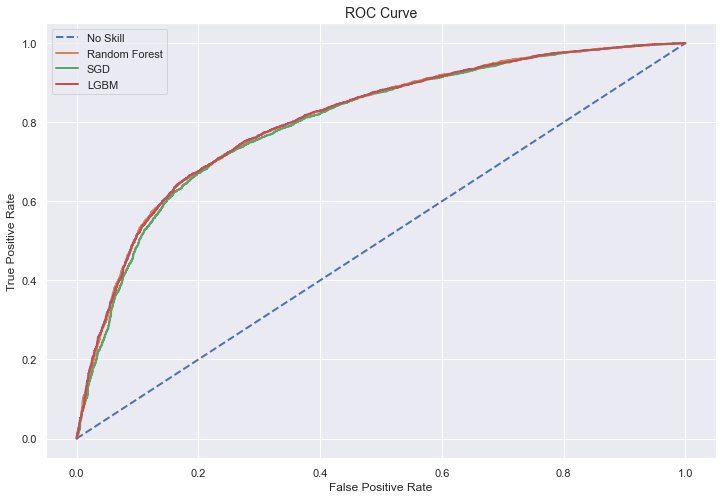

In [43]:
# use the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_valid))]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
cb_fpr, cb_tpr, _ = roc_curve(y_valid, y_pred_cb_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_valid, y_pred_xgb_prob)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_valid, y_pred_lgbm_prob)

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--',linewidth=2, label='No Skill')
plt.plot(cb_fpr, cb_tpr, marker=',',linewidth=2, label='Random Forest')
plt.plot(xgb_fpr, xgb_tpr, marker=',',linewidth=2, label='SGD')
plt.plot(lgbm_fpr, lgbm_tpr, marker=',',linewidth=2, label='LGBM')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show();

## 7.6. Classification Report

Using the method classification_report, the average scores for precision, recall, f1-score are displayed above. **No difference between the three models were observed.**

In [44]:
# generate predictions
y_pred_cb = cb_clf.predict(X_valid)
y_pred_xgb = xgb_clf.predict(X_valid)
y_pred_lgbm = lgbm_clf.predict(X_valid)

print('Classification Report for ' + type(cb_clf).__name__)
print(classification_report(y_valid, y_pred_cb))

print('\nClassification Report for ' + type(xgb_clf).__name__)
print(classification_report(y_valid, y_pred_xgb))

print('\nClassification Report for ' + type(lgbm_clf).__name__)
print(classification_report(y_valid, y_pred_lgbm))



Classification Report for CatBoostClassifier
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3803
           1       0.76      0.71      0.73      4053

    accuracy                           0.74      7856
   macro avg       0.74      0.74      0.74      7856
weighted avg       0.74      0.74      0.74      7856


Classification Report for XGBClassifier
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3803
           1       0.77      0.70      0.73      4053

    accuracy                           0.74      7856
   macro avg       0.74      0.74      0.74      7856
weighted avg       0.74      0.74      0.74      7856


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3803
           1       0.77      0.70      0.73      4053

    accuracy                           0.74      7856


# 8.0. STEP 08 - CROSS-VALIDATION

In this step, a cross-validation was performed on CatBoost Classifier, XGB Classifier, and LGBM Classifier using 10 folds. The training and validation data were combined together in this step.  

Still, the **LGBM Classifier was the best performer with a F1-Score of 0.7250.** Combined with thre results we saw in the previous section, **we will utilize the LGBM Classifier for this project.**

In [51]:
# save probabilities of first lgbm model
# y_pred_lgbm_prob = pickle.dump( y_pred_lgbm_prob, open( 'data\y_pred_lgbm_prob.pkl', 'wb' ) )

# Load Step 06 data
X_train = pickle.load(open ('data\X_train.pkl', 'rb'))
X_valid = pickle.load(open ('data\X_valid.pkl', 'rb'))
y_train = pickle.load(open ('data\y_train.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))


In [52]:
# merging train and valid datasets
X = pd.concat([X_train, X_valid], axis = 0)
y = pd.concat([y_train, y_valid], axis = 0)

# check dataset shape after merging
print(f'X dataset: {X.shape[0]} columns, {X.shape[1]} rows')
print(f'y dataset: {y.shape[0]} rows')

# check balance of classes (0, 1).
print(f"Numbers of instances by class: {np.bincount(y['cardio'])}")

X dataset: 52370 columns, 23 rows
y dataset: 52370 rows
Numbers of instances by class: [25833 26537]


In [53]:
# define CV strategy
cv = StratifiedKFold(n_splits=10, random_state=None)

# define algorithms
models = [CatBoostClassifier(random_state=42, verbose=False),
          XGBClassifier(random_state=42),
          LGBMClassifier(random_state=42, n_jobs=-1)]
 
cross_validation(models, X, y, cv)

,Model Name,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,CatBoostClassifier,0.7519 +/- %0.0046,0.6984 +/- %0.0070,0.7242 +/- %0.0054,0.7962 +/- %0.0068,0.7304 +/- %0.0048
0,XGBClassifier,0.7478 +/- %0.0048,0.6972 +/- %0.0058,0.7216 +/- %0.0047,0.7906 +/- %0.0070,0.7274 +/- %0.0044
0,LGBMClassifier,0.7532 +/- %0.0065,0.6988 +/- %0.0081,0.7250 +/- %0.0063,0.7963 +/- %0.0071,0.7313 +/- %0.0058


# 9.0. STEP 09 - HYPERPARAMETER TUNING

In this step, the random search method for choosing best parameters was used. Although the F1-Score for the tuned model was slightly higher than the default model, we still need to further investigate whether we use the tuned model when using the test dataset.

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html  
https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html  
https://medium.com/@sergei740/hyperparameter-tuning-lightgbm-using-random-grid-search-dc11c2f8c805  
https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9  
https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b  
https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search#Cross-Validation

In [47]:
# Save Step 09 data
# pickle.dump( X, open( 'data\X.pkl', 'wb' ) )
# pickle.dump( y, open( 'data\y.pkl', 'wb' ) )

# Load Step 09 data
X_train = pickle.load(open ('data\X_train.pkl', 'rb'))
X_valid = pickle.load(open ('data\X_valid.pkl', 'rb'))
y_train = pickle.load(open ('data\y_train.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))
y_pred_lgbm_prob = pickle.load(open( 'data\y_pred_lgbm_prob.pkl', 'rb' )) # probabilities of lgbm (first model)
X = pickle.load(open ('data\X.pkl', 'rb'))
y = pickle.load(open ('data\y.pkl', 'rb'))
X_test = pickle.load(open ('data\X_test.pkl', 'rb'))
y_test = pickle.load(open ('data\y_test.pkl', 'rb'))

## 9.1. Random Search

In [17]:
# parameters to be tested
param = {'max_depth': [ 2,  4,  6,  8, 10], 
         'num_leaves': [ 4,  16,  64,  256, 1024],
         'min_data_in_leaf': [ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000], 
         'learning_rate': [0.001, 0.01, 0.05, 0.15, 0.25, 0.35, 0.4, 0.5, 0.55, 0.6],
         'colsample_bytree': [0.1, 0.30, 0.50, 0.70, 1],
         'n_estimators': [ 10,  25,  40,  55,  70,  85, 100],
         'min_child_weight': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
random_search_lgbm(param, 200, X, y)

[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


,mean f1-score,std,parameters
0,0.7389,0.0052,"{'max_depth': 8, 'num_leaves': 256, 'min_data_in_leaf': 950, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'n_estimators': 40, 'min_child_weight': 10}"
0,0.7389,0.0061,"{'max_depth': 8, 'num_leaves': 64, 'min_data_in_leaf': 400, 'learning_rate': 0.001, 'colsample_bytree': 0.7, 'n_estimators': 40, 'min_child_weight': 0.01}"
0,0.7364,0.0064,"{'max_depth': 8, 'num_leaves': 1024, 'min_data_in_leaf': 800, 'learning_rate': 0.001, 'colsample_bytree': 0.5, 'n_estimators': 70, 'min_child_weight': 0.1}"
0,0.7321,0.0064,"{'max_depth': 6, 'num_leaves': 1024, 'min_data_in_leaf': 500, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'n_estimators': 10, 'min_child_weight': 1}"
0,0.7280,0.0070,"{'max_depth': 4, 'num_leaves': 1024, 'min_data_in_leaf': 400, 'learning_rate': 0.01, 'colsample_bytree': 1, 'n_estimators': 70, 'min_child_weight': 10}"
0,0.7277,0.0062,"{'max_depth': 10, 'num_leaves': 256, 'min_data_in_leaf': 700, 'learning_rate': 0.15, 'colsample_bytree': 1, 'n_estimators': 40, 'min_child_weight': 0.001}"
0,0.7274,0.0048,"{'max_depth': 2, 'num_leaves': 64, 'min_data_in_leaf': 350, 'learning_rate': 0.001, 'colsample_bytree': 1, 'n_estimators': 85, 'min_child_weight': 10}"
0,0.7269,0.0054,"{'max_depth': 10, 'num_leaves': 1024, 'min_data_in_leaf': 600, 'learning_rate': 0.25, 'colsample_bytree': 1, 'n_estimators': 40, 'min_child_weight': 1}"
0,0.7268,0.0059,"{'max_depth': 6, 'num_leaves': 256, 'min_data_in_leaf': 650, 'learning_rate': 0.15, 'colsample_bytree': 1, 'n_estimators': 100, 'min_child_weight': 0.001}"
0,0.7266,0.0075,"{'max_depth': 4, 'num_leaves': 256, 'min_data_in_leaf': 700, 'learning_rate': 0.01, 'colsample_bytree': 1, 'n_estimators': 70, 'min_child_weight': 0.1}"


## 9.2. Confusion Matrix (Tuned)

The tuned model reduced the number of false negatives but increased the number of false positives. In contrast, the default model has reduced the false positives but increased the number of false negatives.

[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


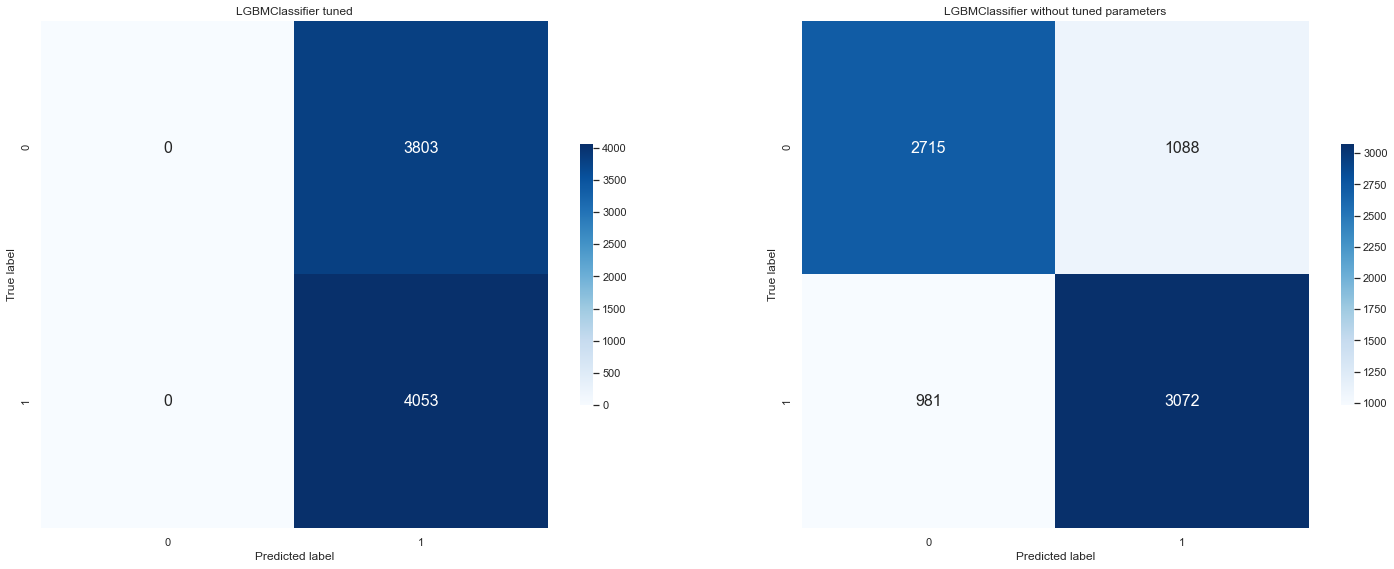

In [62]:
# get cross validation scores for the tuned model
model_lgbm_tuned = LGBMClassifier( objective='binary',
                                max_depth = 8,
                                num_leaves = 256, 
                                min_data_in_leaf= 950, 
                                learning_rate = 0.001, 
                                colsample_bytree=0.7, 
                                n_estimators=40, 
                                min_child_weight=10, random_state=42, n_jobs=-1, silent = True)

# fits the classifier to training data
model_lgbm_tuned.fit(X_train, y_train)
# predict the probabilities
lgbm_tuned_probs = model_lgbm_tuned.predict_proba(X_valid)
# keeps probabilities for the positive outcome only
probs = pd.DataFrame(lgbm_tuned_probs[:, 1], columns=['prob_default'])
# applied the threshold
threshold = 0.45
y_pred = probs['prob_default'].apply(lambda x: 1 if x > threshold else 0)

# instantiate, train and get probabilities from the default lgbm model
lgbm_default = LGBMClassifier(random_state = 42, n_jobs=-1)
lgbm_default.fit(X_train, y_train)
lgbm_default_probs = lgbm_default.predict_proba(X_valid)
probs_default = pd.DataFrame(lgbm_default_probs[:, 1], columns=['prob_default'])
y_pred_default = probs_default['prob_default'].apply(lambda x: 1 if x > threshold else 0)

# plots confusion matrix as heatmap
plt.subplot(121)
single_confusion_matrix(y_valid, y_pred, model_lgbm_tuned, 'tuned');
plt.subplot(122)
single_confusion_matrix(y_valid, y_pred_default, lgbm_default, 'without tuned parameters');

## 9.3. ROC Curve

The default model is slightly better than the tuned model.

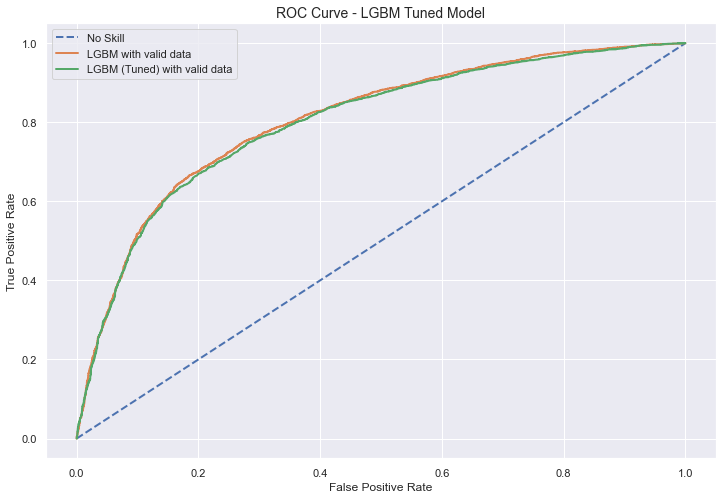

In [49]:
# use the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_valid))]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_valid, ns_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_valid, y_pred_lgbm_prob)
tuned_lgbm_fpr, tuned_lgbm_tpr, _ = roc_curve(y_valid, lgbm_tuned_probs[:,1])

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--',linewidth=2, label='No Skill')
plt.plot(lgbm_fpr, lgbm_tpr, marker=',',linewidth=2, label='LGBM with valid data')
plt.plot(tuned_lgbm_fpr, tuned_lgbm_tpr, marker=',',linewidth=2, label='LGBM (Tuned) with valid data')

# sets plot features
plt.title("ROC Curve - LGBM Tuned Model", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show();

## 9.4. Cross-Validation (Tuned Model)

Overall, we observe a 1% increase on F1-score after tuning. The recall drastically increased to ~15% at the cost of reducing the precision.

In [29]:
# define CV strategy
cv = StratifiedKFold(n_splits=10, random_state=None)

# cross-validation without tuned parameters
cv_model_lgbm_tuned = cross_validation([LGBMClassifier(random_state=42, n_jobs=-1)], X, y, cv) 
cv_model_lgbm_tuned

,Model Name,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,LGBMClassifier,0.7532 +/- %0.0065,0.6988 +/- %0.0081,0.7250 +/- %0.0063,0.7963 +/- %0.0071,0.7313 +/- %0.0058


In [33]:
# run cross-validation with tuned parameters
cv_model_lgbm_tuned = cross_validation([model_lgbm_tuned], X, y, cv, 'tuned') 
cv_model_lgbm_tuned

,Model Name,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,LGBMClassifier tuned,0.6493 +/- %0.0044,0.8573 +/- %0.0075,0.7389 +/- %0.0052,0.7929 +/- %0.0073,0.6931 +/- %0.0059


# 10.0. Performance with Test Dataset

In this section, we test the tuned model and the default model against the test dataset. 
Overall, there is a marginal difference between the F1-scores, 
while the precision rate is significantly higher for the default model even when we calibrated both models.
Therefore, the model chosen is the LGBM model without tuned parameters.

In [34]:
# Save step 10 data
# pickle.dump( model_lgbm_tuned, open( 'data\model_lgbm_tuned.pkl', 'wb' ) )

# Load Step 09 data
X = pickle.load(open ('data\X.pkl', 'rb'))
y = pickle.load(open ('data\y.pkl', 'rb'))
X_test = pickle.load(open ('data\X_test.pkl', 'rb'))
y_test = pickle.load(open ('data\y_test.pkl', 'rb'))
y_valid = pickle.load(open ('data\y_valid.pkl', 'rb'))
model_lgbm_tuned = pickle.load(open ('data\model_lgbm_tuned.pkl', 'rb'))

## 10.1. Modeling

In [55]:
# train tuned model and calculate metrics
tuned_performance_test = ml_performance([LGBMClassifier(colsample_bytree=0.7, learning_rate=0.001, max_depth=8,
               min_child_weight=10, min_data_in_leaf=950, n_estimators=40,
               num_leaves=256, objective='binary', random_state=42)], X, y, X_test, y_test, 0.45, 'no')
tuned_performance_test

Training LGBMClassifier...
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


,Model Name,Recall,Precision,F1-Score,ROC-AUC,Accuracy,Kappa score,Brier score
0,LGBMClassifier,1.0000,0.5067,0.6726,0.7977,0.5067,0.0000,0.2450


In [56]:
# train default model and calculate metrics
tuned_performance_test = ml_performance([model_lgbm_tuned], X, y, X_test, y_test, 0.45, 'no')
tuned_performance_test

Training LGBMClassifier...
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


,Model Name,Recall,Precision,F1-Score,ROC-AUC,Accuracy,Kappa score,Brier score
0,LGBMClassifier,1.0000,0.5067,0.6726,0.7977,0.5067,0.0000,0.2450


## 10.2. Confusion Matrix

[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


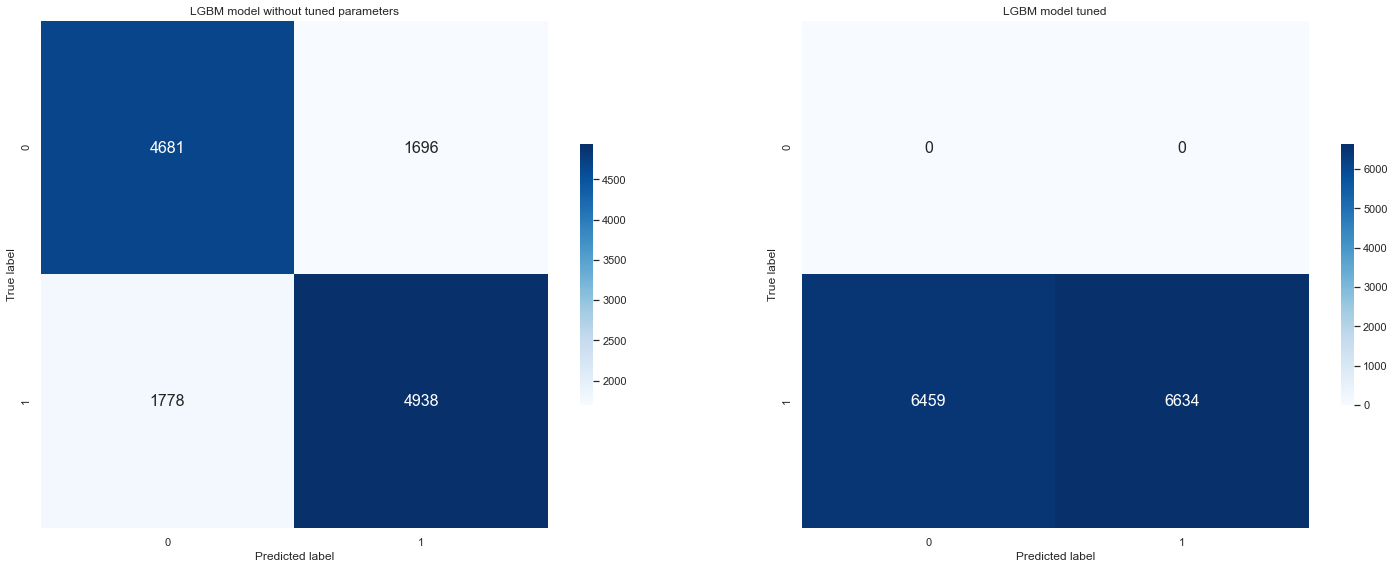

In [57]:
threshold = 0.45
# fits the classifier to data
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm_model.fit(X, y)
# predict the probabilities
clf_probs = lgbm_model.predict_proba(X_test)
# keeps probabilities for the positive outcome only
probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_default'])
# applied the threshold
y_pred = probs['prob_default'].apply(lambda x: 1 if x > threshold else 0)
# calculates confusion matrix
cm = confusion_matrix(y_pred, y_test)
# plots confusion matrix as heatmap
plt.subplot(1,2,1)
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',square=True, annot_kws={"size": 16}, cbar_kws={"shrink": 0.4})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('LGBM model without tuned parameters')

# fits the classifier to test data
model_lgbm_tuned.fit(X, y)
# predict the probabilities
clf_probs = model_lgbm_tuned.predict_proba(X_test)
# keeps probabilities for the positive outcome only
probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_default'])
# applied the threshold
y_pred = probs['prob_default'].apply(lambda x: 1 if x > threshold else 0)
# calculates confusion matrix
cm = confusion_matrix(y_pred, y_test)
# plots confusion matrix as heatmap
plt.subplot(1,2,2)
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                 square=True, annot_kws={"size": 16}, cbar_kws={"shrink": 0.4})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('LGBM model tuned')
# displays the plot
plt.show();

## 10.3. Calibration Curves

https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py  
https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html  
https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/

Since we are not using a model that doesn't need calibration (such as the logistic regression), we will calibrate both the tuned model and the default LGBM model.

To interpret the calibration curve:
- y-axis = actual probability of a positive event for a certain sample  
- x-axis = predicted probability of a positive event for a certain sample   

The closer the curve is to the perfectly calibrated line (45 degrees), the more calibrated the model is.

In [103]:
# Save Step 09 data
# pickle.dump( y_pred_lgbm_prob, open( 'data\y_pred_lgbm_prob.pkl', 'wb' ) ) # probabilities of lgbm (first model)
# pickle.dump( lgbm_tuned_probs, open( 'data\lgbm_tuned_probs.pkl', 'wb' ) ) # probabilities of lgbm (tuned model)
# pickle.dump( model_lgbm_tuned, open( 'data\model_lgbm_tuned.pkl', 'wb' ) ) # model classifier with tuned parameters
# pickle.dump( cv_model_lgbm_tuned, open( 'data\cv_model_lgbm_tuned.pkl', 'wb' ) ) # cv score of tuned model
# pickle.dump( tuned_performance_test, open( 'data/tuned_performance_test.pkl', 'wb' ) ) # performance with test data

# Load Step 09 data
X = pickle.load(open ('data\X.pkl', 'rb'))
y = pickle.load(open ('data\y.pkl', 'rb'))
X_test = pickle.load(open ('data\X_test.pkl', 'rb'))
y_test = pickle.load(open ('data\y_test.pkl', 'rb'))
model_lgbm_tuned = pickle.load(open ('data\model_lgbm_tuned.pkl', 'rb'))

[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


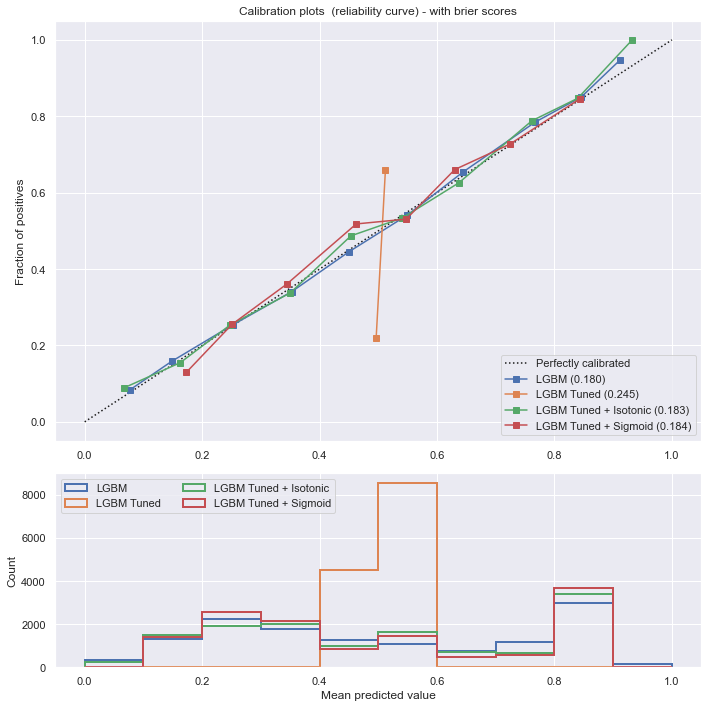

In [58]:
# Plot calibration curve
plot_calibration_curve(model_lgbm_tuned, "LGBM Tuned", 1, X, y, X_test, y_test)

In [59]:
calibrated_scores(model_lgbm_tuned, "LGBM Tuned", 1, X, y, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950
[LightGBM] [Warning] min_data_in_leaf is set=950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=950


,Model Name,Precision,Recall,F1-Score,ROC-AUC,Accuracy,Kappa,Brier Score
0,LGBM,0.7614,0.7018,0.7304,0.7380,0.7375,0.4754,0.1797
0,LGBM Tuned,0.6585,0.8503,0.7422,0.6987,0.7008,0.3990,0.2450
0,LGBM Tuned + Isotonic,0.7370,0.7131,0.7249,0.7259,0.7257,0.4516,0.1828
0,LGBM Tuned + Sigmoid,0.7462,0.6913,0.7177,0.7249,0.7244,0.4493,0.1837


**The Brier, accuracy, kappa, ROC-AUC, precision scores are higher with the default LGBM model**. Since the default model doesn't have a very large F1-Score difference with the LGBM tuned model, we will proceed with the default model.

In [60]:
# merging train and valid datasets
X_final = pd.concat([X, X_test], axis = 0)
y_final = pd.concat([y, y_test], axis = 0)

# check dataset shape after merging
print(f'X dataset: {X_final.shape[0]} columns, {X_final.shape[1]} rows')
print(f'y dataset: {y_final.shape[0]} rows')

# check balance of classes (0, 1).
print(f"Numbers of instances by class: {np.bincount(y_final['cardio'])}")

X dataset: 65463 columns, 23 rows
y dataset: 65463 rows
Numbers of instances by class: [32292 33171]


In [61]:
# define CV strategy
cv = StratifiedKFold(n_splits=10, random_state=None)

# define models for CV
models = [LGBMClassifier(random_state=42, n_jobs=-1), 
          CalibratedClassifierCV(model_lgbm_tuned, method='isotonic', cv=cv)]

cross_validation(models, X_final, y_final, cv, qualifier="")

,Model Name,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,LGBMClassifier,0.7553 +/- %0.0050,0.7014 +/- %0.0074,0.7273 +/- %0.0047,0.7986 +/- %0.0057,0.7335 +/- %0.0041
0,CalibratedClassifierCV,0.7434 +/- %0.0044,0.7062 +/- %0.0082,0.7243 +/- %0.0042,0.7946 +/- %0.0052,0.7276 +/- %0.0033


# 11.0. STEP 11 - BUSINESS PERFORMANCE

The model we chose generate CVD predictions **with precision between XX% and XX%.** Since there are more than 70,000 patients in the dataset, we can calculate the total profit obtained by the firm using the current solution (healthcare software), and also find out what would the total revenue be if the model we have just built were used instead.

Important notes:
- For each 5\% increase in precision rate above 50\%, **there is a \$500 increase for the patients' bill**;
- For unitary percent increase, the patient's bill increase accordingly ($100);
- The diagnosis cost is **\$1000 per patient**;
- For the existing solution, the precision rate varies from **55% (worst scenario) and 65% (best scenario)**;
- For the LGBM model, the precision rate varies from **75.03% (worst scenario) and %76.03 (best scenario)**

In [279]:
worst_software = (500*70000)-(1000*70000)
best_software = (1500*70000)-(1000*70000)
best_model = (2603*70000)-(1000*70000)
worst_model = (2503*70000)-(1000*70000)

df_results = pd.DataFrame({'Best Scenario': [best_software, best_model],
 'Worst Scenario': [worst_software, worst_model]}, index=['Software Solution', 'Machine Learning model'])
df_results['Best Scenario'] = df_results['Best Scenario'].apply(lambda x: "${:,.2f}".format(x))
df_results['Worst Scenario'] = df_results['Worst Scenario'].apply(lambda x: "${:,.2f}".format(x))

df_results

,Best Scenario,Worst Scenario
Software Solution,"$35,000,000.00","$-35,000,000.00"
Machine Learning model,"$112,210,000.00","$105,210,000.00"


In [281]:
(best_model - best_software) / best_model

0.6880848409232688

For 70,000 patients, **the current operation would have a debt of ~\$35 million** if the precision rate is 55\%, **and would have a profit of ~\$35 million** if the precision rate is 65\%.

**Under the model built in this project, the firm would never see a negative value**: with a precision rate of 75.03\%, **profit is around \\$105,2 million**; with an one percent increment (76.03), **profit would be \$112,2. million**. 

Considering only the best scenario possible, **our model would increase revenues to the order of 68\%** compared with the current software solution. 
